# Extract and save features, v2p1

In [ ]:
# ============================================================
# Batch: build & save H0+H1 features for all saved distance shards
# - Input  dir: base_dir/ (from save_distances_sharded)
#     index.csv, meta.json, <cid>/subj_XXXX.npz with D (and maybe D_filled)
# - Output dir: out_dir/
#     index.csv (mirrors input), <cid>/subj_XXXX_feat.npz
#
# Each *_feat.npz contains:
#   # Shared edge index / times
#   pairs              (M,2) int32
#   t_edge             (M,)  float32
#   divide_by_two      ()    bool (as uint8)
#
#   # H0 (MST race, VR time scale)
#   h0_e_idx           (r,)  int32
#   h0_delta_t         (r,)  float32
#   h0_E_counts        (M,)  float32
#   h0_A_weights       (M,)  float32
#   h0_w_mst_time      (r,)  float32
#   h0_mst_mask        (M,)  uint8
#
#   # H1 loops (ragged; CSR-like encoding)
#   L_e_idx            (L,)  int32
#   L_f_idx            (L,)  int32
#   L_b                (L,)  float32
#   L_d                (L,)  float32
#   L_uv               (L,2,2) int32   # [[(u_e,v_e),(u_f,v_f)], ...]
#
#   L_vertices_data    (sum|V_i|,) int32
#   L_vertices_indptr  (L+1,)     int32
#
#   B1_data            (sum|B1_i|,) int32
#   B1_indptr          (L+1,)       int32
#   B2_data            (sum|B2_i|,) int32
#   B2_indptr          (L+1,)       int32
#   Buniq_data         (sum|B_i|,)  int32
#   Buniq_indptr       (L+1,)       int32
#
#   # (optional) node_names_json in the first subject per class if you want
# ============================================================

import csv, json, numpy as np
from pathlib import Path
from typing import Dict, List, Tuple

# ---------- Unified extractor (shared H0 + H1 on distance matrix) ----------
# (identical to the one we discussed; kept here self-contained)

def _pairs_index(n: int):
    I, J = np.triu_indices(n, k=1)
    pairs = np.stack([I, J], axis=1).astype(np.int32)
    tab = -np.ones((n, n), dtype=np.int32)
    tab[I, J] = np.arange(len(I), dtype=np.int32)
    return pairs, tab

def _edge_times_from_D(D: np.ndarray, divide_by_two: bool) -> np.ndarray:
    I, J = np.triu_indices(D.shape[0], k=1)
    t = np.asarray(D, float)[I, J]
    return t/2.0 if divide_by_two else t

class _DSU:
    def __init__(self, n): self.p=list(range(n)); self.r=[0]*n
    def find(self, x):
        while self.p[x]!=x:
            self.p[x]=self.p[self.p[x]]; x=self.p[x]
        return x
    def union(self, a,b):
        a,b=self.find(a),self.find(b)
        if a==b: return False
        if self.r[a]<self.r[b]: self.p[a]=b
        elif self.r[a]>self.r[b]: self.p[b]=a
        else: self.p[b]=a; self.r[a]+=1
        return True

def _extract_h0_from_index(n, pairs, t_edge):
    M = len(pairs)
    edge_ids = np.arange(M, dtype=np.int32)
    order = edge_ids[np.argsort(np.lexsort((edge_ids, np.where(np.isfinite(t_edge), t_edge, np.inf))))]
    dsu = _DSU(n)
    e_idx, comp_labels_list = [], []
    for eid in order:
        te = t_edge[eid]
        if not np.isfinite(te): continue
        u,v = pairs[eid]
        fu, fv = dsu.find(u), dsu.find(v)
        if fu != fv:
            comp = np.array([dsu.find(k) for k in range(n)], dtype=np.int32)
            comp_labels_list.append(comp)
            dsu.union(fu, fv)
            e_idx.append(eid)
            if len(e_idx)==n-1: break
    e_idx = np.array(e_idx, dtype=np.int32)
    w_mst_time = t_edge[e_idx].astype(np.float32)
    d = w_mst_time
    delta_t = np.empty_like(d)
    if d.size:
        delta_t[0]=d[0]; delta_t[1:]=d[1:]-d[:-1] if d.size>1 else delta_t[1:]
    E_counts = np.zeros(M, dtype=np.float32)
    if e_idx.size: E_counts[e_idx]=1.0
    I, J = pairs[:,0], pairs[:,1]
    A_weights = np.zeros(M, dtype=np.float32)
    for i, comp in enumerate(comp_labels_list):
        mask = (comp[I]!=comp[J]) & np.isfinite(t_edge)
        if np.any(mask): A_weights[mask]+=float(delta_t[i])
    mst_mask = np.zeros(M, dtype=np.uint8)
    if e_idx.size: mst_mask[e_idx]=1
    return dict(
        e_idx=e_idx,
        delta_t=delta_t.astype(np.float32),
        E_counts=E_counts,
        A_weights=A_weights,
        w_mst_time=w_mst_time,
        mst_mask=mst_mask
    )

from collections import deque
def _graph_edges_up_to_time(n, pairs, t_edge, t_thresh, exclude_edge=None):
    adj=[[] for _ in range(n)]
    for eid,(u,v) in enumerate(pairs):
        te = t_edge[eid]
        if not np.isfinite(te): continue
        if exclude_edge is not None and eid==exclude_edge: continue
        if te<=t_thresh:
            adj[u].append(v); adj[v].append(u)
    return adj

def _path_vertices(adj, s, t):
    prev=[-1]*len(adj); q=deque([s]); prev[s]=s
    while q:
        u=q.popleft()
        if u==t: break
        for v in adj[u]:
            if prev[v]==-1:
                prev[v]=u; q.append(v)
    if prev[t]==-1: return None
    path=[t]; cur=t
    while cur!=s:
        cur=prev[cur]; path.append(cur)
    path.reverse(); return path

def _extract_h1_from_index(
    n: int,
    pairs: np.ndarray,
    t_edge: np.ndarray,
    mst_mask: np.ndarray,
    max_eps: float | None = None,
    min_pers: float = 0.0,
):
    """
    Vietoris–Rips H1 via triangle columns + Z2 reduction, aligned with PH ordering.

    - Edges with t_edge > max_eps are treated as +inf (excluded) if max_eps is provided.
    - Row (edge) order is by (t_edge, edge_id) — the same order used in PH.
    - Pivot selection uses the *youngest* edge by that order.
    - Birth edges must have an existing u->v path using strictly-earlier edges (row-order),
      otherwise they are skipped (prevents MST edges from birthing cycles).
    - Loops with persistence <= min_pers are skipped.
    """
    # --- 0) apply epsilon cap (to match Gudhi’s max_edge_length) ---
    t_masked = np.asarray(t_edge, float).copy()
    if max_eps is not None:
        bad = t_masked > float(max_eps)
        t_masked[bad] = np.inf

    M = len(pairs)
    edge_ids = np.arange(M, dtype=np.int32)

    # --- 1) global row order for edges: sort by (time, id) ---
    row_order = np.lexsort((edge_ids, t_masked))  # sort by (t_edge, edge_id)
    rank = np.empty(M, dtype=np.int32)
    rank[row_order] = np.arange(M, dtype=np.int32)

    def younger_key(eid: int):
        return (t_masked[eid], eid)

    def argmax_youngest(eid_set: set[int]) -> int:
        # "max" by filtration order (i.e., the youngest edge)
        return max(eid_set, key=lambda e: younger_key(e))

    # --- 2) build triangle list (only fully finite triangles) ---
    tab = -np.ones((n, n), dtype=np.int32)
    for eid, (i, j) in enumerate(pairs):
        tab[i, j] = eid

    tris = []  # each = ( (a,b,c), [e_ab,e_bc,e_ac], t_tri, last_edge )
    for a in range(n - 2):
        for b in range(a + 1, n - 1):
            e_ab = tab[a, b]
            if e_ab < 0 or not np.isfinite(t_masked[e_ab]):  # respect cap
                continue
            for c in range(b + 1, n):
                e_ac = tab[a, c]; e_bc = tab[b, c]
                if e_ac < 0 or e_bc < 0:
                    continue
                if not (np.isfinite(t_masked[e_ac]) and np.isfinite(t_masked[e_bc])):
                    continue
                tri_edges = [e_ab, e_bc, e_ac]
                # triangle appears when all 3 edges exist → time = max (by filtration order)
                last_edge = argmax_youngest(set(tri_edges))
                t_tri = float(t_masked[last_edge])
                tris.append(((a, b, c), tri_edges, t_tri, last_edge))

    # sort triangles by (t_tri, vertices) for deterministic reduction
    tris.sort(key=lambda x: (x[2], x[0]))

    # --- 3) Z2 column reduction over edges; store pivot edge → death info ---
    pivot_col: dict[int, set[int]] = {}  # pivot edge → reduced column (set of edges)
    pivot_time: dict[int, float] = {}    # pivot edge → death time (triangle time)
    pivot_last: dict[int, int] = {}      # pivot edge → the triangle's youngest edge (a convenience)

    for (_abc, tri_edges, t_tri, last_e) in tris:
        col = set(tri_edges)
        while col:
            p = argmax_youngest(col)
            if p in pivot_col:
                col ^= pivot_col[p]
            else:
                pivot_col[p] = set(col)
                pivot_time[p] = t_tri
                pivot_last[p] = last_e
                break

    # --- 4) births from pivot edges; require a prior u->v path; drop tiny bars ---
    loops = []

    # helpers to build adjacency by rank threshold
    from collections import deque

    def build_adj_until(rank_thresh: int, inclusive: bool, exclude_edge: int | None = None):
        adj = [[] for _ in range(n)]
        for eid, (x, y) in enumerate(pairs):
            if not np.isfinite(t_masked[eid]):
                continue
            if exclude_edge is not None and eid == exclude_edge:
                continue
            if (rank[eid] < rank_thresh) or (inclusive and rank[eid] <= rank_thresh):
                adj[x].append(y); adj[y].append(x)
        return adj

    def reachable_nodes(seed: int, adj):
        seen = {seed}; q = deque([seed])
        while q:
            u = q.popleft()
            for v in adj[u]:
                if v not in seen:
                    seen.add(v); q.append(v)
        return seen

    # iterate pivot edges in row order for determinism
    for e_idx in sorted(pivot_time.keys(), key=lambda e: (t_masked[e], e)):
        b = float(t_masked[e_idx]); d = float(pivot_time[e_idx])
        if not (np.isfinite(b) and np.isfinite(d)):
            continue
        if (d - b) <= float(min_pers):
            continue  # remove ~zero persistence

        u, v = map(int, pairs[e_idx])

        # Require a u→v path using strictly earlier rows (rank < rank[e_idx])
        adj_b = build_adj_until(rank[e_idx], inclusive=False, exclude_edge=e_idx)
        # BFS
        prev = [-1] * n; q = deque([u]); prev[u] = u
        while q:
            w = q.popleft()
            if w == v:
                break
            for z in adj_b[w]:
                if prev[z] == -1:
                    prev[z] = w; q.append(z)
        if prev[v] == -1:
            # No pre-existing path → this edge is not a 1-cycle birth (likely MST). Skip.
            continue

        # reconstruct a path (loop's vertex order along the path)
        path = [v]; cur = v
        while cur != u:
            cur = prev[cur]
            path.append(cur)
        path.reverse()
        L_vertices = list(map(int, path))

        # components at b (strict) and at death (<= last edge of death triangle)
        last_e = int(pivot_last[e_idx])
        adj_comp_b = build_adj_until(rank[e_idx], inclusive=False, exclude_edge=None)
        seen_b = reachable_nodes(L_vertices[0], adj_comp_b)

        adj_comp_d = build_adj_until(rank[last_e], inclusive=True, exclude_edge=None)
        seen_d = reachable_nodes(L_vertices[0], adj_comp_d)

        # edge sets within those components and within rank windows
        comp_b_edges = {
            eid for eid, (a, b_) in enumerate(pairs)
            if (a in seen_b and b_ in seen_b) and np.isfinite(t_masked[eid]) and (rank[eid] < rank[e_idx])
        }
        comp_d_edges = {
            eid for eid, (a, b_) in enumerate(pairs)
            if (a in seen_d and b_ in seen_d) and np.isfinite(t_masked[eid]) and (rank[eid] <= rank[last_e])
        }

        # boundary subsets (exclude MST edges & the last edge)
        B1 = {eid for eid in comp_b_edges if (not mst_mask[eid]) and (eid != last_e)}
        B2 = {
            eid for eid in comp_d_edges
            if (rank[eid] > rank[e_idx]) and (not mst_mask[eid]) and (eid != last_e)
        }

        loops.append(dict(
            e_idx=int(e_idx), f_idx=int(last_e),
            e_uv=tuple(map(int, pairs[e_idx])),
            f_uv=tuple(map(int, pairs[last_e])),
            b=b, d=d,
            L_vertices=L_vertices,
            B1_idx=sorted(B1), B2_idx=sorted(B2), B_idx=None
        ))

    # --- 5) make boundary-unique list (B_idx) like before ---
    loops.sort(key=lambda L: L["d"])
    used = set()
    for L in loops:
        tilde = set(L["B1_idx"]) | set(L["B2_idx"])
        uniq = tilde - used
        L["B_idx"] = sorted(uniq)
        used |= tilde

    return loops


def extract_h01_from_D(
    D: np.ndarray,
    divide_by_two: bool = True,
    max_eps: float | None = None,
    min_pers: float = 0.0,
):
    D = np.asarray(D, float)
    n = D.shape[0]
    pairs, _ = _pairs_index(n)
    t_edge = _edge_times_from_D(D, divide_by_two=divide_by_two)

    h0 = _extract_h0_from_index(n, pairs, t_edge)
    loops = _extract_h1_from_index(
        n, pairs, t_edge, h0["mst_mask"],
        max_eps=max_eps, min_pers=min_pers
    )
    return dict(
        pairs=pairs,
        t_edge=t_edge.astype(np.float32),
        divide_by_two=np.uint8(bool(divide_by_two)),
        h0=h0,
        loops=loops,
    )


# ---------- Ragged packing for H1 loops ----------
def _pack_loops_ragged(loops: List[Dict], pairs: np.ndarray):
    L = len(loops)
    L_e_idx = np.array([L_i['e_idx'] for L_i in loops], dtype=np.int32)
    L_f_idx = np.array([L_i['f_idx'] for L_i in loops], dtype=np.int32)
    L_b     = np.array([L_i['b'] for L_i in loops], dtype=np.float32)
    L_d     = np.array([L_i['d'] for L_i in loops], dtype=np.float32)

    # uv pairs aligned with e_idx and f_idx (convenience)
    L_uv = np.zeros((L,2,2), dtype=np.int32)
    for i,L_i in enumerate(loops):
        L_uv[i,0,:] = np.array(L_i['e_uv'], dtype=np.int32)
        L_uv[i,1,:] = np.array(L_i['f_uv'], dtype=np.int32)

    def to_csr(list_of_lists: List[List[int]]):
        indptr=[0]; data=[]
        for arr in list_of_lists:
            data.extend(arr); indptr.append(len(data))
        return np.array(data, dtype=np.int32), np.array(indptr, dtype=np.int32)

    L_vertices_data, L_vertices_indptr = to_csr([L_i['L_vertices'] for L_i in loops])
    B1_data, B1_indptr   = to_csr([L_i['B1_idx'] for L_i in loops])
    B2_data, B2_indptr   = to_csr([L_i['B2_idx'] for L_i in loops])
    Buniq_data, Buniq_indptr = to_csr([L_i['B_idx']  for L_i in loops])

    return dict(
        L_e_idx=L_e_idx, L_f_idx=L_f_idx, L_b=L_b, L_d=L_d, L_uv=L_uv,
        L_vertices_data=L_vertices_data, L_vertices_indptr=L_vertices_indptr,
        B1_data=B1_data, B1_indptr=B1_indptr,
        B2_data=B2_data, B2_indptr=B2_indptr,
        Buniq_data=Buniq_data, Buniq_indptr=Buniq_indptr
    )

def _unpack_loops_ragged(arrs: Dict) -> List[Dict]:
    def from_csr(data, indptr):
        out=[]; idx0=0
        for k in range(len(indptr)-1):
            idx1 = indptr[k+1]
            out.append(list(map(int, data[idx0:idx1])))
            idx0 = idx1
        return out
    L = int(arrs["L_e_idx"].shape[0])
    e_idx = arrs["L_e_idx"]; f_idx=arrs["L_f_idx"]
    b = arrs["L_b"]; d = arrs["L_d"]; L_uv = arrs["L_uv"]
    L_vertices = from_csr(arrs["L_vertices_data"], arrs["L_vertices_indptr"])
    B1 = from_csr(arrs["B1_data"], arrs["B1_indptr"])
    B2 = from_csr(arrs["B2_data"], arrs["B2_indptr"])
    Buniq = from_csr(arrs["Buniq_data"], arrs["Buniq_indptr"])
    loops=[]
    for i in range(L):
        loops.append(dict(
            e_idx=int(e_idx[i]), f_idx=int(f_idx[i]),
            e_uv=tuple(map(int, L_uv[i,0])),
            f_uv=tuple(map(int, L_uv[i,1])),
            b=float(b[i]), d=float(d[i]),
            L_vertices=L_vertices[i],
            B1_idx=B1[i], B2_idx=B2[i], B_idx=Buniq[i]
        ))
    return loops

# ---------- Batch I/O ----------
def build_features_for_sharded(base_dir: str,
                               out_dir: str,
                               divide_by_two: bool = True,
                               prefer_filled: bool = False,
                               prefer_vr: bool = True,      # <-- NEW
                               overwrite: bool = False):
    """
    Read all distance shards from base_dir (created by save_distances_sharded),
    compute shared H0+H1 features, and save to out_dir with mirrored structure.
    If prefer_vr=True, we use 'D_vr' (if present) so infinite entries are already capped
    at 'cap = eps_max + delta' and consistent across subjects.
    """
    base = Path(base_dir); out = Path(out_dir)
    out.mkdir(parents=True, exist_ok=True)

    # mirror index.csv into output for easy lookup
    index_in = base / "index.csv"
    if not index_in.exists():
        raise FileNotFoundError(f"Missing {index_in}")
    index_out = out / "index.csv"
    if not index_out.exists():
        index_out.write_text(index_in.read_text())

    # load meta.json (to grab eps_max & cap if available)
    meta_in = base / "meta.json"
    vr_eps_max = None
    vr_cap = None
    if meta_in.exists():
        meta = json.loads(meta_in.read_text())
        vr = (meta.get("distance_info", {}) or {}).get("vr", {})
        vr_eps_max = float(vr.get("eps_max")) if "eps_max" in vr else None
        vr_cap = float(vr.get("cap")) if "cap" in vr else None
        # copy meta.json over (nice to have alongside features)
        if not (out/"meta.json").exists():
            (out/"meta.json").write_text(meta_in.read_text())

    # iterate rows
    with index_in.open() as f:
        r = csv.DictReader(f)
        for row in r:
            cid = row["cid"]
            rel = row["file"]      # e.g., "Group1/subj_0123.npz"
            in_npz = base / rel
            out_npz = out / rel.replace(".npz", "_feat.npz")
            out_npz.parent.mkdir(parents=True, exist_ok=True)
            if out_npz.exists() and not overwrite:
                continue

            with np.load(in_npz) as z:
                # priority: D_vr > D_filled > D
                if prefer_vr and ("D_vr" in z.files):
                    D = z["D_vr"]
                elif prefer_filled and ("D_filled" in z.files):
                    D = z["D_filled"]
                else:
                    D = z["D"]
                # fallback: if subject-level cap present in the shard, prefer it
                subj_eps_max = float(z["eps_max"]) if "eps_max" in z.files else vr_eps_max
                subj_cap     = float(z["cap"])     if "cap"     in z.files else vr_cap

            # extract features
            pack = extract_h01_from_D(
                D,
                divide_by_two=divide_by_two,
                max_eps=subj_eps_max,   # from meta/shard; same value you used as Gudhi's max_edge_length
                min_pers=0.0            # set e.g. 1e-9 if you filtered zero bars in Gudhi
            )
            pairs, t_edge = pack["pairs"], pack["t_edge"]
            h0 = pack["h0"]; loops = pack["loops"]
            L_pack = _pack_loops_ragged(loops, pairs)

            # write subject feature file (also stash eps_max/cap for easy filtering later)
            save_dict = dict(
                pairs=pairs,
                t_edge=t_edge,
                divide_by_two=np.array(pack["divide_by_two"], dtype=np.uint8),

                h0_e_idx=h0["e_idx"],
                h0_delta_t=h0["delta_t"],
                h0_E_counts=h0["E_counts"],
                h0_A_weights=h0["A_weights"],
                h0_w_mst_time=h0["w_mst_time"],
                h0_mst_mask=h0["mst_mask"].astype(np.uint8),

                **L_pack
            )
            if subj_eps_max is not None:
                save_dict["vr_eps_max"] = np.array(subj_eps_max, dtype=np.float32)
            if subj_cap is not None:
                save_dict["vr_cap"] = np.array(subj_cap, dtype=np.float32)

            np.savez_compressed(out_npz, **save_dict)

    print(f"[ok] features written to: {out_dir}")

def load_subject_k(base_dir, cid, k=0, use_filled_if_available=False):
    rows = []
    with (Path(base_dir)/"index.csv").open() as f:
        r = csv.DictReader(f)
        for row in r:
            if row["cid"] == cid:
                rows.append(row)
    if not rows:
        raise FileNotFoundError(f"No shards for class {cid}.")
    rows.sort(key=lambda r: r["file"])
    zpath = Path(base_dir) / rows[k]["file"]
    with np.load(zpath) as z:
        return z["D_filled"] if (use_filled_if_available and "D_filled" in z) else z["D"]

def load_subject_features(feat_path: str) -> Dict:
    """
    Load one *_feat.npz and reconstruct a user-friendly dict.
    """
    with np.load(feat_path, allow_pickle=True) as z:
        pairs = z["pairs"]; t_edge = z["t_edge"]; divide_by_two = bool(z["divide_by_two"].item())
        h0 = dict(
            e_idx=z["h0_e_idx"], delta_t=z["h0_delta_t"],
            E_counts=z["h0_E_counts"], A_weights=z["h0_A_weights"],
            w_mst_time=z["h0_w_mst_time"], mst_mask=z["h0_mst_mask"].astype(bool)
        )
        rag = {k: z[k] for k in
               ["L_e_idx","L_f_idx","L_b","L_d","L_uv",
                "L_vertices_data","L_vertices_indptr",
                "B1_data","B1_indptr","B2_data","B2_indptr","Buniq_data","Buniq_indptr"]}
        loops = _unpack_loops_ragged(rag)
    return dict(
        edge_index=dict(pairs=pairs, t_edge=t_edge, divide_by_two=divide_by_two),
        h0=h0,
        h1=dict(loops=loops)
    )


In [28]:
# Build once, using D with +inf (preferred for topology)
build_features_for_sharded(
    base_dir="data/connectome_D_v2",
    out_dir="data/connectome_feat_v2p1",
    divide_by_two=True,     # VR radius time
    prefer_filled=False,    # keep +inf semantics
    prefer_vr=True,         # <-- use the VR-safe distances
    overwrite=True
)

[ok] features written to: data/connectome_feat_v2p1


In [30]:
# Load one subject’s features later
feat_path = "data/connectome_feat_v2p1/Group1/sub_0003_feat.npz"
feat = load_subject_features(feat_path)

# H0 vectors for pooling into your existing fitter:
pairs    = feat["edge_index"]["pairs"]
E_counts = feat["h0"]["E_counts"]
A_weights= feat["h0"]["A_weights"]

# H1 loops (for your triangulation likelihood):
loops = feat["h1"]["loops"]
# each loop has: e_idx,f_idx,b,d,L_vertices,B1_idx,B2_idx,B_idx, e_uv, f_uv

In [31]:
import numpy as np

def _is_dict_of_arrays(loops):
    return isinstance(loops, dict)

def _get_key(loops_dict, *candidates):
    for k in candidates:
        if k in loops_dict: 
            return k
    return None

def _coerce_to_list_of_dicts(loops):
    """
    Returns: list_of_dicts, with keys: 'b','d','e_idx','f_idx','uv','vertices','B1','B2','Buniq'
    Any missing keys become None.
    Supports:
      - dict of arrays/lists (preferred)
      - list/array of dicts
    """
    wanted = ["b","d","e_idx","f_idx","uv","vertices","B1","B2","Buniq"]

    if _is_dict_of_arrays(loops):
        # map alternative key names if needed
        keymap = {
            "b": _get_key(loops, "b","birth","L_b"),
            "d": _get_key(loops, "d","death","L_d"),
            "e_idx": _get_key(loops, "e_idx","edge_idx","L_e_idx"),
            "f_idx": _get_key(loops, "f_idx","face_idx","L_f_idx"),
            "uv": _get_key(loops, "uv","L_uv"),
            "vertices": _get_key(loops, "vertices","L_vertices"),
            "B1": _get_key(loops, "B1","L_B1"),
            "B2": _get_key(loops, "B2","L_B2"),
            "Buniq": _get_key(loops, "Buniq","L_Buniq"),
        }

        # determine n_loops from any present 1D field
        n_loops = None
        for k in ["b","d","e_idx","f_idx","uv"]:
            km = keymap[k]
            if km is not None and loops[km] is not None:
                arr = loops[km]
                if k == "uv":   # expect shape (n,2)
                    n_loops = arr.shape[0]
                elif hasattr(arr, "shape") and arr.ndim >= 1:
                    n_loops = arr.shape[0]
                elif isinstance(arr, (list, tuple)):
                    n_loops = len(arr)
                if n_loops is not None:
                    break

        # build list-of-dicts
        out = []
        for i in range(int(n_loops or 0)):
            row = {}
            for k in wanted:
                km = keymap[k]
                if km is None or loops.get(km, None) is None:
                    row[k] = None
                else:
                    val = loops[km]
                    if k in ("vertices","B1","B2","Buniq"):
                        # ragged: expect object array or list+indptr already unpacked by your helper
                        # try index if list-like
                        try:
                            row[k] = val[i]
                        except Exception:
                            row[k] = None
                    else:
                        # index 1D fields
                        try:
                            row[k] = val[i]
                        except Exception:
                            row[k] = None
            out.append(row)
        return out

    else:
        # assume list/array of dicts
        list_like = list(loops)
        # normalize keys to our canonical names where possible
        def normalize(d):
            m = {}
            m["b"] = d.get("b", d.get("birth", d.get("L_b")))
            m["d"] = d.get("d", d.get("death", d.get("L_d")))
            m["e_idx"] = d.get("e_idx", d.get("edge_idx", d.get("L_e_idx")))
            m["f_idx"] = d.get("f_idx", d.get("face_idx", d.get("L_f_idx")))
            m["uv"] = d.get("uv", d.get("L_uv"))
            m["vertices"] = d.get("vertices", d.get("L_vertices"))
            m["B1"] = d.get("B1", d.get("L_B1"))
            m["B2"] = d.get("B2", d.get("L_B2"))
            m["Buniq"] = d.get("Buniq", d.get("L_Buniq"))
            return m
        return [normalize(d) for d in list_like]

def summarize_loops(loops):
    L = _coerce_to_list_of_dicts(loops)
    n = len(L)
    if n == 0:
        print("No loops found.")
        return

    b = np.array([x["b"] for x in L], dtype=float)
    d = np.array([x["d"] for x in L], dtype=float)
    lifetime = d - b

    has_inf_death = np.isinf(d).any()
    num_inf = int(np.isinf(d).sum())
    num_nan = int(np.isnan(b).sum() + np.isnan(d).sum())

    # lengths (counts) for ragged pieces if present
    n_vertices = np.array([ (len(x["vertices"]) if isinstance(x["vertices"], (list, np.ndarray)) else np.nan) for x in L ])
    n_buniq    = np.array([ (len(x["Buniq"])    if isinstance(x["Buniq"],    (list, np.ndarray)) else np.nan) for x in L ])

    print(f"#loops = {n}")
    print(f"birth  : min={np.nanmin(b):.6g}, median={np.nanmedian(b):.6g}, max={np.nanmax(b):.6g}")
    print(f"death  : min={np.nanmin(d):.6g}, median={np.nanmedian(d):.6g}, max={np.nanmax(d):.6g}")
    print(f"life   : min={np.nanmin(lifetime):.6g}, median={np.nanmedian(lifetime):.6g}, max={np.nanmax(lifetime):.6g}")
    print(f"undying(+inf death) = {num_inf}; NaNs in b/d = {num_nan}")
    if np.isfinite(n_vertices).any():
        print(f"#vertices per loop (if available): median={np.nanmedian(n_vertices):.1f}, min={np.nanmin(n_vertices):.0f}, max={np.nanmax(n_vertices):.0f}")
    if np.isfinite(n_buniq).any():
        print(f"#unique boundary edges per loop (if available): median={np.nanmedian(n_buniq):.1f}, min={np.nanmin(n_buniq):.0f}, max={np.nanmax(n_buniq):.0f}")

    # show a few examples
    kshow = min(3, n)
    print("\nExamples:")
    for i in range(kshow):
        vi = L[i]["vertices"]
        print(f"  loop[{i}]: b={b[i]:.6g}, d={d[i]:.6g}, life={(d[i]-b[i]):.6g}, "
              f"vertices={len(vi) if isinstance(vi,(list,np.ndarray)) else 'NA'}")

def loop_to_edges(loop_row, pairs):
    """
    Return the undirected node-pairs for this loop using 'e_idx' if present,
    otherwise fall back to 'Buniq' as boundary edges (indices into the same pairs).
    """
    e_idx = loop_row.get("e_idx", None)
    if isinstance(e_idx, (list, np.ndarray)):
        return pairs[np.asarray(e_idx, dtype=int)]
    Buniq = loop_row.get("Buniq", None)
    if isinstance(Buniq, (list, np.ndarray)):
        return pairs[np.asarray(Buniq, dtype=int)]
    return None

def inspect_loop(loops, pairs, i=0, show_edges=True):
    L = _coerce_to_list_of_dicts(loops)
    if not (0 <= i < len(L)):
        raise IndexError(f"Loop index {i} out of range 0..{len(L)-1}")
    row = L[i]
    b, d = float(row["b"]), float(row["d"])
    life = d - b
    nv = len(row["vertices"]) if isinstance(row["vertices"], (list, np.ndarray)) else None
    ne = len(row["Buniq"]) if isinstance(row["Buniq"], (list, np.ndarray)) else None
    print(f"loop[{i}]")
    print(f"  birth={b:.6g}, death={d:.6g}, lifetime={life:.6g}")
    print(f"  #vertices={nv}, #boundary_edges(unique)={ne}")
    if show_edges:
        edges = loop_to_edges(row, pairs)
        if edges is None:
            print("  (No edge indices available to map to node-pairs.)")
        else:
            print(f"  edges (node pairs) shape: {edges.shape}")
            print(f"  first few edges:\n{edges[:min(10, len(edges))]}")

def loops_to_dataframe(loops):
    """
    Optional: flatten to a pandas DataFrame for quick filtering/sorting.
    """
    try:
        import pandas as pd
    except Exception:
        print("pandas not available; skipping DataFrame creation.")
        return None

    L = _coerce_to_list_of_dicts(loops)
    rows = []
    for i, r in enumerate(L):
        b = float(r["b"]) if r["b"] is not None else np.nan
        d = float(r["d"]) if r["d"] is not None else np.nan
        nv = len(r["vertices"]) if isinstance(r["vertices"], (list, np.ndarray)) else np.nan
        nb = len(r["Buniq"]) if isinstance(r["Buniq"], (list, np.ndarray)) else np.nan
        rows.append({
            "loop_id": i,
            "birth": b,
            "death": d,
            "lifetime": d - b if (np.isfinite(b) and np.isfinite(d)) else np.inf if np.isfinite(b) and np.isinf(d) else np.nan,
            "n_vertices": nv,
            "n_boundary_unique": nb,
        })
    df = pd.DataFrame(rows).sort_values(["lifetime","birth"], ascending=[False, True]).reset_index(drop=True)
    return df

# ===============================
# Quick use
# ===============================
print("=== Loop summary ===")
summarize_loops(loops)

print("\n=== Inspect loop 0 ===")
inspect_loop(loops, pairs, i=0, show_edges=True)

print("\n=== Optional DataFrame (top 10 by lifetime) ===")
df = loops_to_dataframe(loops)
if df is not None:
    print(df.head(10).to_string(index=False))


=== Loop summary ===
#loops = 16
birth  : min=0.045249, median=0.0574217, max=0.11506
death  : min=0.0452869, median=0.067303, max=0.131646
life   : min=3.79272e-05, median=0.00749245, max=0.0390821
undying(+inf death) = 0; NaNs in b/d = 0
#vertices per loop (if available): median=5.0, min=4, max=8

Examples:
  loop[0]: b=0.045249, d=0.0452869, life=3.79272e-05, vertices=4
  loop[1]: b=0.05031, d=0.0508414, life=0.000531424, vertices=4
  loop[2]: b=0.0556217, d=0.0558551, life=0.000233401, vertices=4

=== Inspect loop 0 ===
loop[0]
  birth=0.045249, death=0.0452869, lifetime=3.79272e-05
  #vertices=4, #boundary_edges(unique)=None
  (No edge indices available to map to node-pairs.)

=== Optional DataFrame (top 10 by lifetime) ===
 loop_id    birth    death  lifetime  n_vertices  n_boundary_unique
      14 0.080393 0.119475  0.039082           7                NaN
      11 0.056415 0.079254  0.022839           8                NaN
      15 0.112402 0.131646  0.019244           4         

In [32]:
loops

[{'e_idx': 2228,
  'f_idx': 941,
  'e_uv': (34, 36),
  'f_uv': (12, 36),
  'b': 0.045249003916978836,
  'd': 0.04528693109750748,
  'L_vertices': [34, 12, 27, 36],
  'B1_idx': [101,
   102,
   111,
   323,
   344,
   354,
   798,
   839,
   846,
   932,
   939,
   940,
   942,
   972,
   973,
   980,
   987,
   1270,
   1272,
   1450,
   1514,
   1521,
   1574,
   1581,
   1698,
   1871,
   1872,
   1902,
   1903,
   2026,
   2031,
   2132,
   2162,
   2163,
   2227,
   2259,
   2260,
   2267,
   2274,
   2314,
   2322,
   2398,
   3283,
   3290,
   3297,
   3304,
   3311],
  'B2_idx': [],
  'B_idx': [101,
   102,
   111,
   323,
   344,
   354,
   798,
   839,
   846,
   932,
   939,
   940,
   942,
   972,
   973,
   980,
   987,
   1270,
   1272,
   1450,
   1514,
   1521,
   1574,
   1581,
   1698,
   1871,
   1872,
   1902,
   1903,
   2026,
   2031,
   2132,
   2162,
   2163,
   2227,
   2259,
   2260,
   2267,
   2274,
   2314,
   2322,
   2398,
   3283,
   3290,
   3297,
   330

In [29]:
from pathlib import Path

dirs = [
    Path("data/connectome_feat_v2p1/Group1"),
    Path("data/connectome_feat_v2p1/Group2"),
    Path("data/connectome_feat_v2p1/Group3"),
]

for d in dirs:
    if d.is_dir():
        top = sum(1 for p in d.iterdir() if p.is_file())
        rec = sum(1 for p in d.rglob("*") if p.is_file())
        print(d, f"\n  files (top level): {top}\n  files (recursive): {rec}")
    else:
        print(f"{d} — NOT FOUND")



data/connectome_feat_v2p1/Group1 
  files (top level): 21
  files (recursive): 21
data/connectome_feat_v2p1/Group2 
  files (top level): 46
  files (recursive): 46
data/connectome_feat_v2p1/Group3 
  files (top level): 37
  files (recursive): 37


# Take a look at the PH barplot

In [37]:
# pip install gudhi matplotlib numpy
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from gudhi import RipsComplex

# (re)use the previous helpers -----------------------------------------------

def _sanitize_distance_matrix(D: np.ndarray) -> np.ndarray:
    D = np.asarray(D, dtype=float)
    if D.ndim != 2 or D.shape[0] != D.shape[1]:
        raise ValueError("D must be a square distance matrix")
    D = 0.5 * (D + D.T)
    np.fill_diagonal(D, 0.0)
    if (D < -1e-12).any():
        raise ValueError("Distance matrix has negative entries")
    D[D < 0] = 0.0
    return D

def vr_persistence_from_distance(
    D: np.ndarray,
    max_dim: int = 2,
    max_edge: float | None = None,
    field: int = 2,
    min_persistence: float = 0.0,
):
    """
    Build VR complex from a distance matrix and compute persistence.
    Returns (simplex_tree, persistence, max_edge_used).
    """
    D = _sanitize_distance_matrix(D)

    if max_edge is None:
        iu = np.triu_indices_from(D, k=1)
        dvals = D[iu]
        max_edge = np.percentile(dvals[dvals > 0], 95) if (dvals > 0).any() else 0.0

    rips = RipsComplex(distance_matrix=D, max_edge_length=max_edge)
    st = rips.create_simplex_tree(max_dimension=max_dim)
    persistence = st.persistence(
        homology_coeff_field=field,
        min_persistence=min_persistence
    )
    return st, persistence, max_edge

# plotting --------------------------------------------------------------------

def _manual_barcode(
    persistence,
    dims=None,                 # None -> plot all nonnegative dims present
    cap: float | None = None,
    sort_by: str = "birth",    # "birth" | "length" | "death"
    line_width: float = 2.0,
):
    # collect intervals
    if dims is None:
        dims = sorted({d for d, _ in persistence if d >= 0})
    dims = list(dims)

    records = [(dim, float(b), float(d)) for dim, (b, d) in persistence if dim in set(dims)]

    if not records:
        fig, ax = plt.subplots()
        ax.text(0.5, 0.5, "No intervals", ha="center", va="center")
        ax.set_axis_off()
        return ax

    finite_deaths = [d for _, _, d in records if np.isfinite(d)]
    if len(finite_deaths) == 0:
        finite_deaths = [1.0]
    default_cap = 1.05 * max(finite_deaths)
    x_cap = default_cap if (cap is None) else cap

    key_fn = {
        "birth":  lambda r: (r[1], np.isfinite(r[2]), r[2]),
        "death":  lambda r: (np.isfinite(r[2]), r[2]),
        "length": lambda r: ((min(r[2], x_cap) - r[1])),
    }[sort_by]

    ax = plt.gca()
    y0 = 0
    y_ticks, y_ticklabels = [], []

    for d in dims:
        block = [r for r in records if r[0] == d]
        block.sort(key=key_fn)
        for i, (_, b, de) in enumerate(block):
            de_plot = de if np.isfinite(de) else x_cap
            ax.hlines(y=y0 + i, xmin=b, xmax=de_plot, linewidth=line_width)
        if block:
            y_ticks.append(y0 + len(block) / 2 - 0.5)
            y_ticklabels.append(f"H{d}")
            y0 += len(block) + 2  # gap

    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_ticklabels)
    ax.set_xlim(left=0.0, right=x_cap)
    ax.set_xlabel(r"$\epsilon$")
    ax.set_ylabel("homology")
    ax.grid(True, axis="x", linestyle=":", alpha=0.4)
    return ax

def plot_all_dims_barcode(
    persistence,
    dpi=450,
    filename: str | None = None,
    big_fonts: bool = True,
    use_latex: bool = True,
    cap: float | None = None,
    sort_by: str = "birth",
):
    """
    Single stacked barcode containing ALL homology dimensions present (H0, H1, H2, ...).
    """
    if big_fonts:
        plt.rcParams.update({
            "font.size": 16,
            "axes.labelsize": 18,
            "xtick.labelsize": 14,
            "ytick.labelsize": 14,
            "savefig.dpi": dpi,
            "text.usetex": bool(use_latex),
        })

    plt.figure()
    _manual_barcode(persistence, dims=None, cap=cap, sort_by=sort_by)
    plt.tight_layout()
    if filename:
        plt.savefig(filename, dpi=dpi, bbox_inches="tight")
    plt.show()

def save_per_dimension_barcodes(
    persistence,
    out_dir: str = "barcodes",
    prefix: str = "vr",
    dpi: int = 450,
    big_fonts: bool = True,
    use_latex: bool = True,
    cap: float | None = None,
    sort_by: str = "birth",
):
    """
    Save one PNG per homology dimension that appears in 'persistence'.
    """
    dims_present = sorted({d for d, _ in persistence if d >= 0})
    Path(out_dir).mkdir(parents=True, exist_ok=True)

    if big_fonts:
        plt.rcParams.update({
            "font.size": 16,
            "axes.labelsize": 18,
            "xtick.labelsize": 14,
            "ytick.labelsize": 14,
            "savefig.dpi": dpi,
            "text.usetex": bool(use_latex),
        })

    # compute a default cap once (consistent across dims)
    finite_deaths = [float(death) for _, (_, death) in persistence if np.isfinite(death)]
    default_cap = 1.05 * max(finite_deaths) if finite_deaths else 1.0
    x_cap = default_cap if (cap is None) else cap

    for d in dims_present:
        plt.figure()
        _manual_barcode(persistence, dims=[d], cap=x_cap, sort_by=sort_by)
        plt.tight_layout()
        fout = Path(out_dir) / f"{prefix}_H{d}_barcode.png"
        plt.savefig(fout, dpi=dpi, bbox_inches="tight")
        plt.close()
        print("Saved:", fout)

# # -----------------------
# # Example usage
# # -----------------------
# if __name__ == "__main__":
#     # Toy point cloud -> distance matrix
#     rng = np.random.default_rng(42)
#     X = np.vstack([
#         rng.normal([0, 0], 0.05, size=(20, 2)),
#         rng.normal([1.0, 0.2], 0.05, size=(20, 2)),
#         rng.normal([0.5, 0.9], 0.05, size=(20, 2)),
#     ])
#     D = np.sqrt(((X[:, None, :] - X[None, :, :])**2).sum(-1))

#     # Compute persistence up to H2 (adjust as needed)
#     st, persistence, max_edge = vr_persistence_from_distance(D, max_dim=2)

#     # (A) One stacked figure with ALL dimensions
#     plot_all_dims_barcode(
#         persistence,
#         filename="vr_all_dims_barcode.png",
#         dpi=450, big_fonts=True, use_latex=True,
#         cap=max_edge,            # cap ∞ bars at VR cutoff
#         sort_by="birth"          # or "length" / "death"
#     )

#     # (B) Also dump one PNG per dimension (H0, H1, H2, ...)
#     save_per_dimension_barcodes(
#         persistence,
#         out_dir="barcodes",
#         prefix="vr",
#         dpi=450, big_fonts=True, use_latex=True,
#         cap=max_edge, sort_by="birth"
#     )


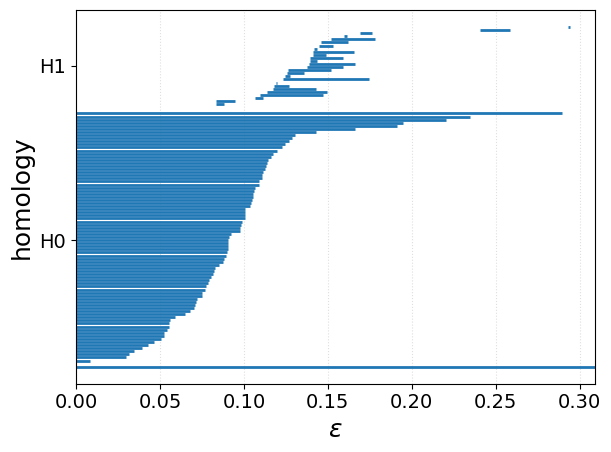

In [39]:
D = load_subject_k("data/connectome_D_v2", cid="Group1", k=3, use_filled_if_available=True)
st, persistence, max_edge = vr_persistence_from_distance(D, max_dim=2)

# (A) One stacked figure with ALL dimensions
plot_all_dims_barcode(
    persistence, use_latex=False
)

# Check bottleneck distance for subjects across 3 classes

Found 104 subjects across 3 groups.
H0 bars per subject (min/med/max): 83 83.0 83
H1 bars per subject (min/med/max): 8 21.5 33


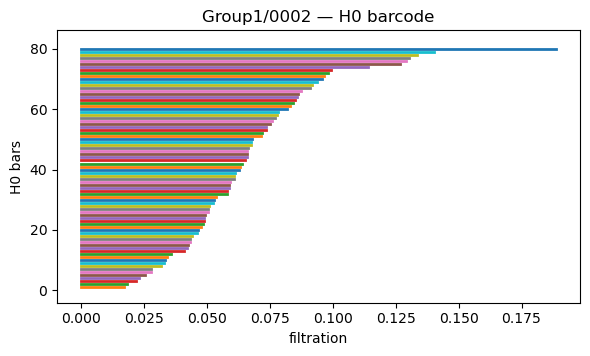

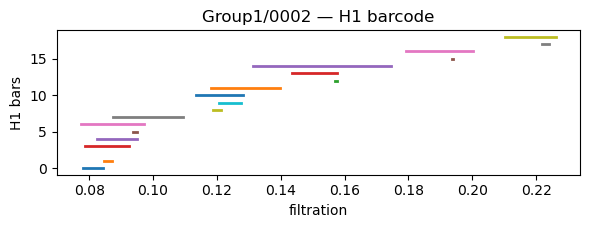

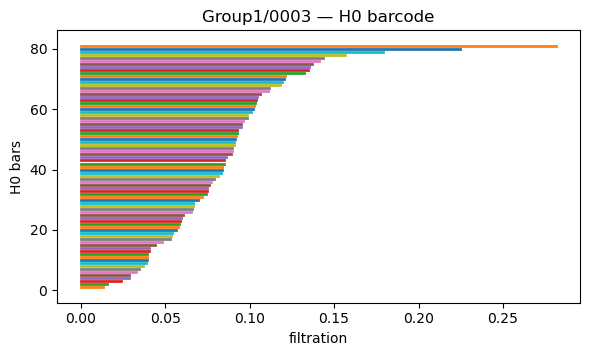

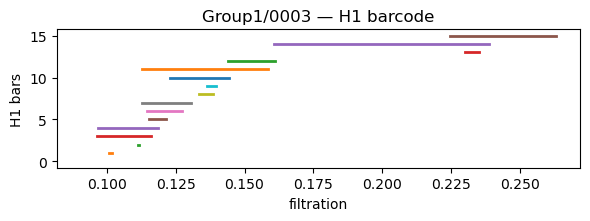

[bottleneck] backend = gudhi.hera


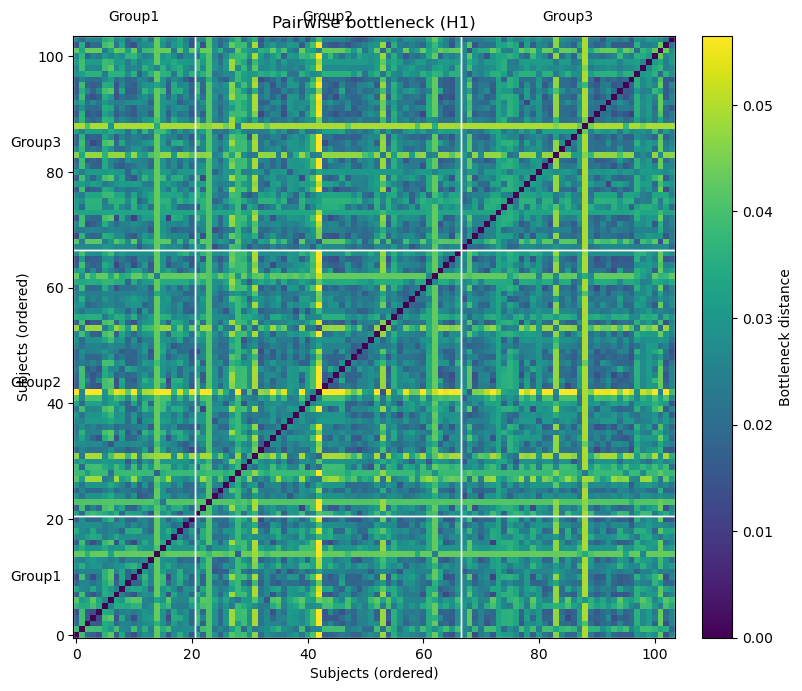

[bottleneck] backend = gudhi.hera


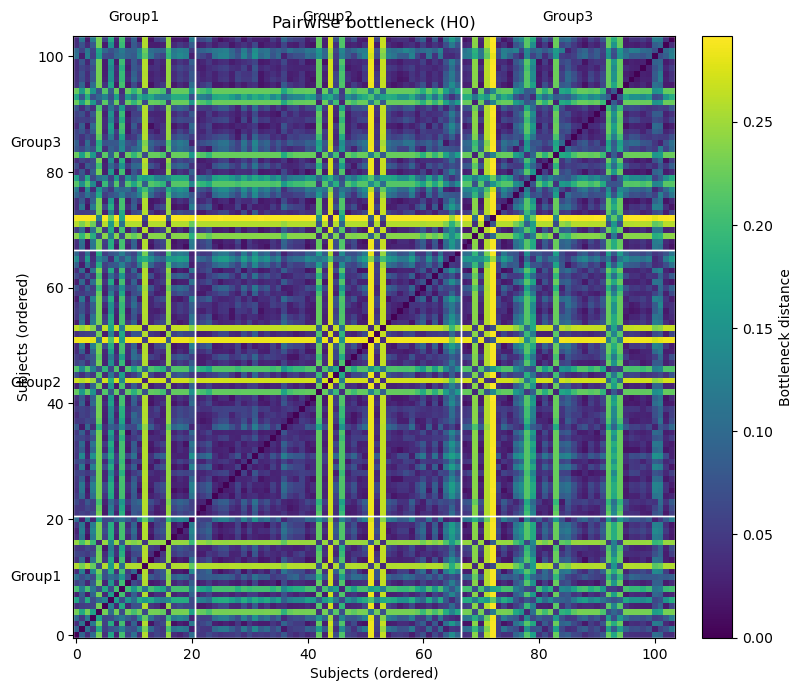

In [ ]:
# ================================================
# Raw-D → VR(TDA) with GUDHI: H0/H1 + Bottleneck
# ================================================
import re
from pathlib import Path
from typing import List, Optional, Tuple, Union

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from gudhi import RipsComplex

# -------------------
# CONFIG
# -------------------
RAW_DIR = "data/connectome_D_v2"
GROUPS: Optional[List[str]] = None     # e.g., ["Group1","Group2","Group3"]; None → auto
MAX_EDGE_QUANTILE = 0.95               # raise (0.98–0.99) if H1 bars are empty
SHOW_RANGE: Optional[Tuple[float,float]] = None  # e.g., (0.0, 0.6) to clamp heatmap

# -------------------
# Helpers
# -------------------

def _natkey(s: str):
    return [int(t) if t.isdigit() else t.lower() for t in re.split(r"(\d+)", s)]

def scan_raw_shards(root: str, groups: Optional[List[str]] = None):
    """Return files and (cid, subj_id) keys for .npz that contain 'D'."""
    root = Path(root)
    if groups is None:
        groups = sorted([d.name for d in root.iterdir() if d.is_dir()])
    files, keys = [], []
    for g in groups:
        gdir = root / g
        if not gdir.exists():
            continue
        for p in sorted(gdir.glob("*.npz"), key=lambda x: _natkey(x.name)):
            try:
                with np.load(p) as z:
                    if "D" in z.files:
                        files.append(p)
                        m = re.findall(r"(\d+)", p.stem)
                        s = m[-1] if m else p.stem
                        keys.append((g, s))
            except Exception:
                continue
    return files, keys

def choose_threshold(D: np.ndarray, q: float = 0.95) -> float:
    X = D[np.isfinite(D)]
    X = X[X > 0]
    if X.size == 0:
        return 0.0
    qv = float(np.quantile(X, q))
    return max(qv, 1e-12)

def vr_diagram_from_D(
    D_raw: np.ndarray,
    hom_dim: int,
    max_edge_length: float,
    min_persistence: float = 0.0
) -> np.ndarray:
    """
    Build VR diagram for given homology. Caps non-finite entries
    above threshold so they never enter the complex. Ensures triangles for H1.
    """
    D = np.asarray(D_raw, dtype=float).copy()
    np.fill_diagonal(D, 0.0)
    if not np.all(np.isfinite(D)):
        D[~np.isfinite(D)] = max_edge_length * 1e6  # safely ignored
    max_dim = hom_dim + 1 if hom_dim >= 1 else 1

    rc = RipsComplex(distance_matrix=D, max_edge_length=max_edge_length)
    st = rc.create_simplex_tree(max_dimension=max_dim)
    st.persistence(min_persistence=min_persistence)
    arr = st.persistence_intervals_in_dimension(hom_dim)
    return np.asarray(arr, dtype=float) if arr is not None else np.empty((0, 2), float)

def plot_barcode(diag: np.ndarray, dim: int, title: str):
    if diag.size == 0:
        fig, ax = plt.subplots(figsize=(6, 2))
        ax.text(0.5, 0.5, "No bars", ha="center", va="center")
        ax.set_axis_off()
        fig.suptitle(title)
        plt.tight_layout()
        return fig, ax
    fig, ax = plt.subplots(figsize=(6, 2 + 0.02*len(diag)))
    for i, (b, d) in enumerate(diag):
        ax.plot([b, d], [i, i], lw=2)
    ax.set_xlabel("filtration")
    ax.set_ylabel(f"H{dim} bars")
    ax.set_title(title)
    plt.tight_layout()
    return fig, ax

# ---- bottleneck backends
def _get_bottleneck():
    try:
        from gudhi.hera import bottleneck_distance as bn
        return bn, "gudhi.hera"
    except Exception:
        pass
    try:
        from persim import bottleneck as bn
        return bn, "persim"
    except Exception:
        pass
    try:
        from gudhi.representations.metrics import BottleneckDistance
        bd = BottleneckDistance()
        return lambda a,b: float(bd(a,b)), "gudhi.representations.metrics"
    except Exception:
        pass
    raise ImportError("No bottleneck backend. `pip install persim` is the quickest.")

def pairwise_bottleneck(diagrams: List[np.ndarray]) -> np.ndarray:
    bn, backend = _get_bottleneck()
    print(f"[bottleneck] backend = {backend}")
    N = len(diagrams)
    B = np.zeros((N, N), float)
    for i in range(N):
        for j in range(i + 1, N):
            B[i, j] = B[j, i] = float(bn(diagrams[i], diagrams[j]))
    return B

def _order_keys(keys: List[Tuple[str,Union[int,str]]]) -> List[int]:
    return sorted(range(len(keys)), key=lambda i: (keys[i][0], _natkey(str(keys[i][1]))))

def plot_block_heatmap(
    B: np.ndarray,
    keys: List[Tuple[str,Union[int,str]]],
    title: str,
    *,
    cmap: str = "viridis",
    vmin: float | None = None,
    vmax: float | None = None,
    norm: mcolors.Normalize | None = None
):
    order = _order_keys(keys)
    BB = B[np.ix_(order, order)]
    kperm = [keys[i] for i in order]

    # group boundaries
    labels = [cid for (cid, _) in kperm]
    group_order = []
    for g in labels:
        if not group_order or group_order[-1] != g:
            group_order.append(g)
    bounds = []
    last = 0
    for g in group_order:
        cnt = sum(1 for x in labels if x == g)
        if cnt:
            bounds.append((last, last + cnt, g))
            last += cnt

    cmap_obj = plt.get_cmap(cmap).copy()
    kwargs = dict(origin="lower", cmap=cmap_obj, interpolation="nearest")
    if norm is not None:
        kwargs["norm"] = norm
    else:
        kwargs["vmin"] = vmin
        kwargs["vmax"] = vmax

    fig, ax = plt.subplots(figsize=(8, 7))
    im = ax.imshow(BB, **kwargs)
    cb = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cb.set_label("Bottleneck distance")

    for a, b, g in bounds:
        ax.axhline(a - 0.5, color="white", lw=1)
        ax.axhline(b - 0.5, color="white", lw=1)
        ax.axvline(a - 0.5, color="white", lw=1)
        ax.axvline(b - 0.5, color="white", lw=1)
        mid = (a + b - 1) / 2
        ax.text(-0.02, mid, g, va="center", ha="right", transform=ax.get_yaxis_transform())
        ax.text(mid, 1.02, g, va="bottom", ha="center", transform=ax.get_xaxis_transform())

    ax.set_xlabel("Subjects (ordered)")
    ax.set_ylabel("Subjects (ordered)")
    ax.set_title(title)
    plt.tight_layout()
    return fig, ax

def make_finite_h0(diag: np.ndarray) -> np.ndarray:
    """Cap infinite deaths in H0 so bottleneck distance is well-defined."""
    if diag.size == 0:
        return diag
    d = np.asarray(diag, float).copy()
    finite_deaths = d[np.isfinite(d[:, 1]), 1]
    base = finite_deaths.max() if finite_deaths.size else (d[:, 0].max() if d.size else 1.0)
    cap = float(base * 1.01 + 1e-9)
    d[~np.isfinite(d[:, 1]), 1] = cap
    return d

# -------------------
# Run
# -------------------
files, keys = scan_raw_shards(RAW_DIR, GROUPS)
assert files, f"No raw D shards with key 'D' found under {RAW_DIR}"
print(f"Found {len(files)} subjects across {len(set([c for c,_ in keys]))} groups.")

# Build diagrams
diags0, diags1 = [], []
for p in files:
    with np.load(p) as z:
        D = np.asarray(z["D"], dtype=float)
    mel = choose_threshold(D, q=MAX_EDGE_QUANTILE)
    d0 = vr_diagram_from_D(D, hom_dim=0, max_edge_length=mel, min_persistence=0.0)
    d1 = vr_diagram_from_D(D, hom_dim=1, max_edge_length=mel, min_persistence=0.0)
    # gentle retry if H1 empty
    if d1.size == 0 and MAX_EDGE_QUANTILE < 0.99:
        mel2 = choose_threshold(D, q=0.99)
        d1 = vr_diagram_from_D(D, hom_dim=1, max_edge_length=mel2, min_persistence=0.0)
    diags0.append(d0)
    diags1.append(d1)

# Quick stats
h0lens = [d.shape[0] for d in diags0]
h1lens = [d.shape[0] for d in diags1]
print("H0 bars per subject (min/med/max):", min(h0lens or [0]), np.median(h0lens) if h0lens else 0, max(h0lens or [0]))
print("H1 bars per subject (min/med/max):", min(h1lens or [0]), np.median(h1lens) if h1lens else 0, max(h1lens or [0]))

# Barcodes for two examples
for i in range(min(2, len(files))):
    cid, sid = keys[i]
    plot_barcode(diags0[i], 0, f"{cid}/{sid} — H0 barcode")
    plot_barcode(diags1[i], 1, f"{cid}/{sid} — H1 barcode")
plt.show()

# Bottleneck (H1)
B1 = pairwise_bottleneck(diags1)
vmin, vmax = (SHOW_RANGE if SHOW_RANGE else (None, None))
plot_block_heatmap(B1, keys, title="Pairwise bottleneck (H1)", vmin=vmin, vmax=vmax)
plt.show()

# Bottleneck (H0)
diags0_finite = [make_finite_h0(d) for d in diags0]
B0 = pairwise_bottleneck(diags0_finite)
plot_block_heatmap(B0, keys, title="Pairwise bottleneck (H0)", vmin=vmin, vmax=vmax)
plt.show()


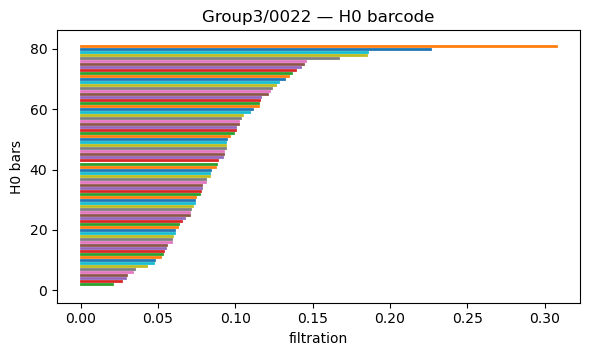

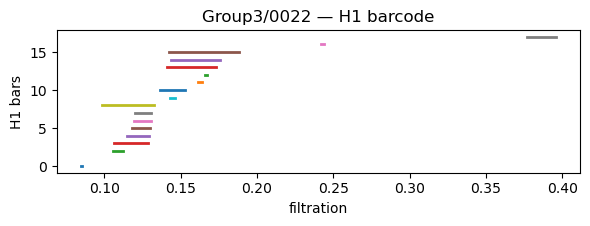

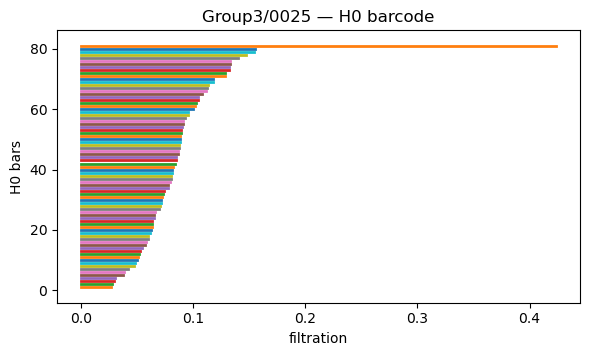

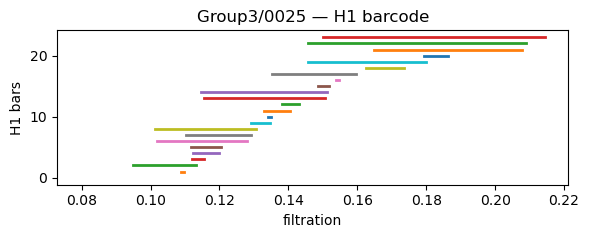

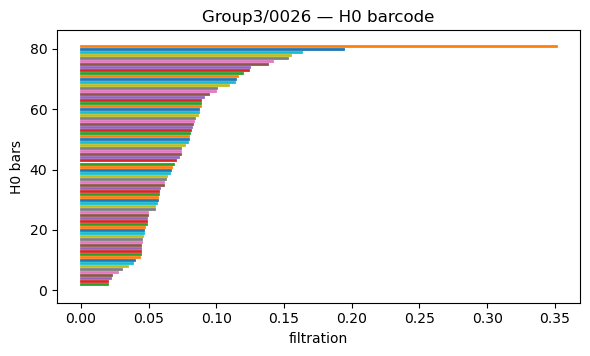

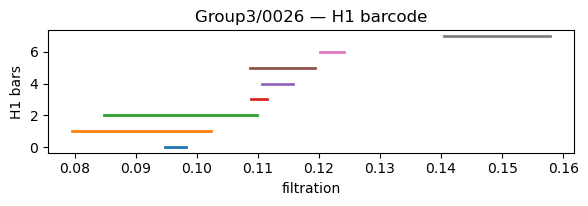

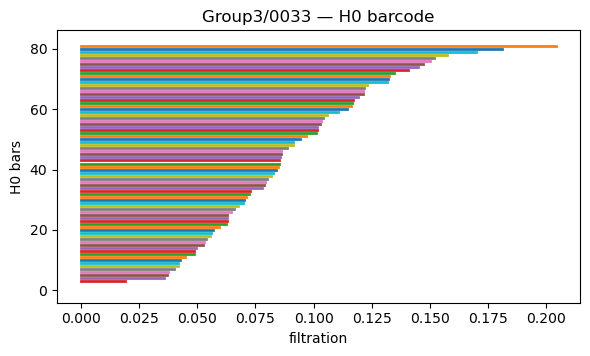

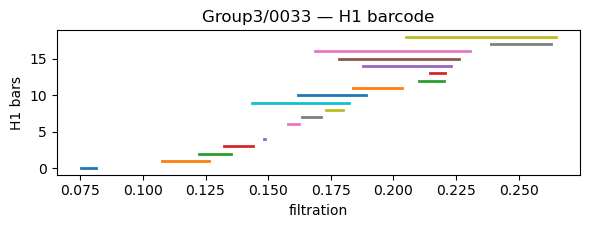

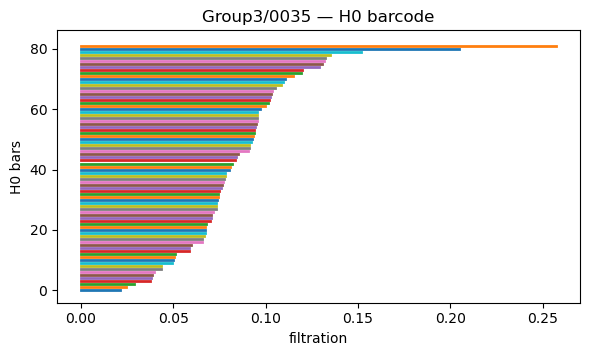

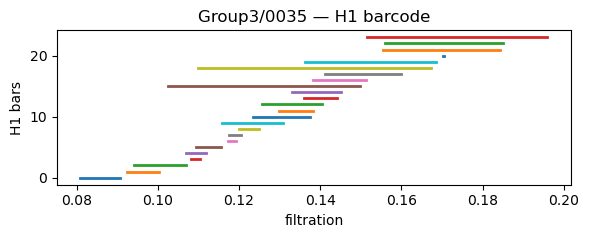

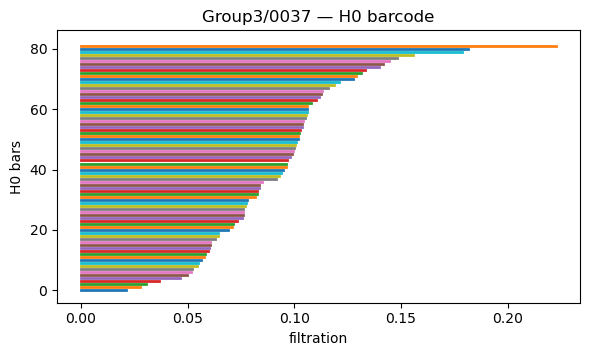

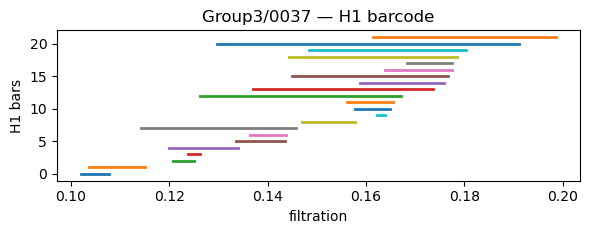

In [45]:
for i in range(77,83):
    cid, sid = keys[i]
    plot_barcode(diags0[i], 0, f"{cid}/{sid} — H0 barcode")
    plot_barcode(diags1[i], 1, f"{cid}/{sid} — H1 barcode")
plt.show()

[bottleneck] backend = gudhi.hera


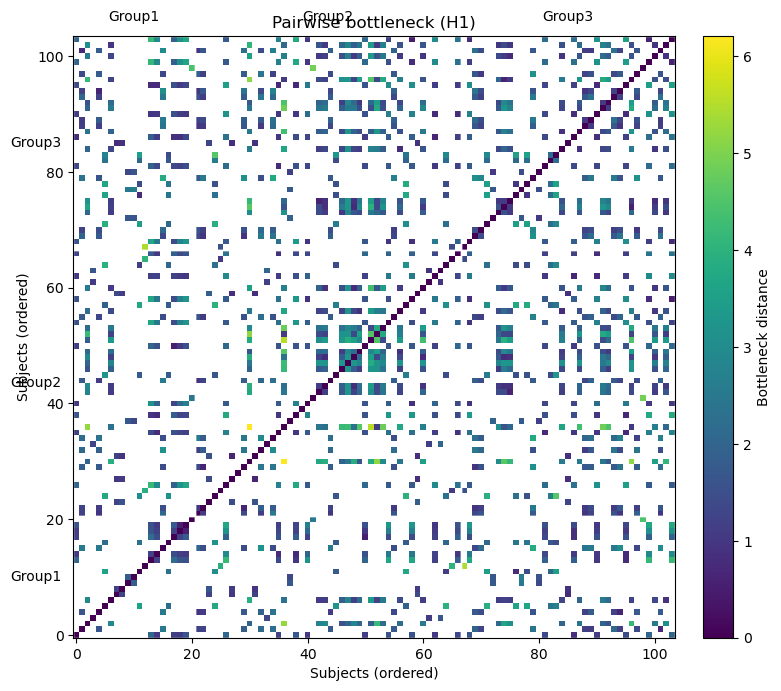

[bottleneck] backend = gudhi.hera


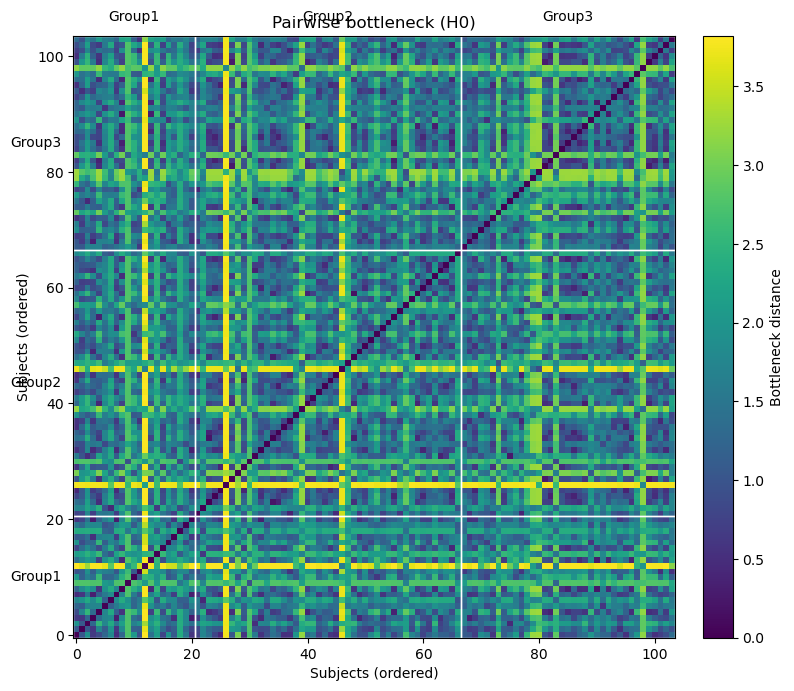

In [35]:
# Bottleneck (H1)
SHOW_RANGE = (None, None)
B1 = pairwise_bottleneck(diags1)
vmin, vmax = (SHOW_RANGE if SHOW_RANGE else (None, None))
plot_block_heatmap(B1, keys, title="Pairwise bottleneck (H1)", vmin=vmin, vmax=vmax)
plt.show()

# Bottleneck (H0)
# SHOW_RANGE = (0.0, 2)
diags0_finite = [make_finite_h0(d) for d in diags0]
B0 = pairwise_bottleneck(diags0_finite)
vmin, vmax = (SHOW_RANGE if SHOW_RANGE else (None, None))
plot_block_heatmap(B0, keys, title="Pairwise bottleneck (H0)", vmin=vmin, vmax=vmax)
plt.show()

## Save the bottleneck heatmap

In [26]:
# Bottleneck (H1)
B1 = pairwise_bottleneck(diags1)
vmin, vmax = (SHOW_RANGE if SHOW_RANGE else (None, None))
fig1, ax1 = plot_block_heatmap(
    B1, keys, title="Pairwise bottleneck (H1)",
    vmin=vmin, vmax=vmax  # or norm=...
)


# save it
out_dir = Path("figs/bn")
out_dir.mkdir(parents=True, exist_ok=True)
fig1.savefig(out_dir/"bn_H1_heatmap.png", dpi=450, bbox_inches="tight")
fig1.savefig(out_dir/"bn_H1_heatmap.pdf", bbox_inches="tight")  # vector for LaTeX
plt.close(fig1)  # free memory if looping

[bottleneck] backend = gudhi.hera


In [27]:
# Bottleneck (H0)
B0 = pairwise_bottleneck(diags0_finite)
fig0, ax0 = plot_block_heatmap(
    B0, keys, title="Pairwise bottleneck (H0)",
    vmin=vmin, vmax=vmax
)
fig0.savefig(out_dir/"bn_H0_heatmap.png", dpi=450, bbox_inches="tight")
fig0.savefig(out_dir/"bn_H0_heatmap.svg", bbox_inches="tight")
plt.close(fig0)


[bottleneck] backend = gudhi.hera


# Helper

In [ ]:
# ============================================================
# H0+H1 training + full artifact saving:
#   - NUTS draws (phi), Lambda_hat
#   - trace & ACF plots
#   - predictive log-likelihood confusion matrix (CSV + PNG)
#   - latent 2D coordinate plots from Lambda_hat
# ============================================================

import os, csv, json, math, time
from pathlib import Path
from typing import Dict, List, Tuple
import numpy as np
import jax, jax.numpy as jnp
from jax import lax
from numpyro.infer import MCMC, NUTS
import matplotlib as mpl
import matplotlib.pyplot as plt

# ---------- Matplotlib style ----------
import shutil
HAS_TEX = shutil.which("latex") is not None
mpl.rcParams.update({
    "text.usetex": HAS_TEX,
    "savefig.dpi": 450,     # ≥400 as requested
    "font.size": 18,
    "axes.labelsize": 20,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
})

# ---------- Stable helpers ----------
def segsum(data: jnp.ndarray, segment_ids: jnp.ndarray, num_segments: int):
    """Segmented sum via scatter-add. JIT/grad friendly. Handles ND `data`."""
    segment_ids = segment_ids.astype(jnp.int32)
    out_shape = (int(num_segments),) + data.shape[1:]
    out = jnp.zeros(out_shape, dtype=data.dtype)
    return out.at[segment_ids].add(data)

def _log1mexp(x: jnp.ndarray) -> jnp.ndarray:
    x = jnp.asarray(x)
    log2 = jnp.log(jnp.array(2.0, dtype=x.dtype))
    return jnp.where(x <= log2, jnp.log(-jnp.expm1(-x)), jnp.log1p(-jnp.exp(-x)))

def acf(series: np.ndarray, max_lag: int = 100) -> np.ndarray:
    """Unbiased ACF up to max_lag."""
    x = np.asarray(series, float)
    x = x - x.mean()
    n = x.size
    var = np.dot(x, x) / n
    if var == 0:
        return np.zeros(max_lag+1)
    corr = np.correlate(x, x, mode='full')[n-1 : n+max_lag] / n
    return corr / var

def plot_trace(series: np.ndarray, png_path: Path, xlabel=r"$\mathrm{draw}$", ylabel=r"$\mathrm{value}$"):
    fig, ax = plt.subplots(figsize=(8, 3.2))
    ax.plot(np.arange(len(series)), series, lw=1.0)
    ax.set_xlabel(xlabel); ax.set_ylabel(ylabel)
    fig.tight_layout()
    fig.savefig(png_path); plt.close(fig)

def plot_acf(series: np.ndarray, png_path: Path, max_lag: int = 100, xlabel=r"$\mathrm{lag}$", ylabel=r"$\mathrm{ACF}$"):
    r = acf(series, max_lag=max_lag)
    fig, ax = plt.subplots(figsize=(8, 3.2))
    ax.vlines(np.arange(len(r)), 0, r, lw=1.2)
    ax.scatter(np.arange(len(r)), r, s=12)
    ax.set_xlabel(xlabel); ax.set_ylabel(ylabel)
    fig.tight_layout()
    fig.savefig(png_path); plt.close(fig)

# ---------- Load pooled inputs directly from feature dir ----------
def _pairs_to_iu(pairs: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """Return (iu0, iu1) = the exact i<j pairs (already provided)."""
    return pairs[:,0], pairs[:,1]

def pool_class_h0h1_from_feat_dir(
    feat_dir: str,
    cid: str,
    exclude_undying: bool = True,
    tol: float = 1e-9,   # numerical cushion when comparing to cap
):
    import csv, json, numpy as np
    from pathlib import Path

    base = Path(feat_dir)
    idx = base / "index.csv"
    rows = [row for row in csv.DictReader(idx.open()) if row["cid"] == cid]
    if not rows:
        raise FileNotFoundError(f"No subjects for class {cid} in {idx}")

    # Optional global fallback cap from meta.json
    fallback_cap = None
    meta_path = base / "meta.json"
    if meta_path.exists():
        try:
            meta = json.loads(meta_path.read_text())
            vr = (meta.get("distance_info", {}) or {}).get("vr", {})
            if "cap" in vr:
                fallback_cap = float(vr["cap"])
        except Exception:
            pass

    # Pairs template
    first_feat = base / rows[0]["file"].replace(".npz", "_feat.npz")
    with np.load(first_feat) as z0:
        pairs = z0["pairs"].astype(np.int32)
        M = pairs.shape[0]

    # H0 pools
    E_tot = np.zeros(M, dtype=np.float32)
    A_tot = np.zeros(M, dtype=np.float32)

    # H1 pools
    e_all = []; f_all = []; b_all = []; d_all = []
    B1_edge_idx = []; B1_loop_ids = []
    B2_edge_idx = []; B2_loop_ids = []

    loops_offset = 0  # pooled loop id base

    for row in rows:
        zpath = base / row["file"].replace(".npz", "_feat.npz")
        with np.load(zpath) as z:
            # H0 accumulate (sanity: shared pairs)
            if z["pairs"].shape != pairs.shape or not np.array_equal(z["pairs"], pairs):
                raise AssertionError(f"'pairs' mismatch in {zpath}")
            E_tot += z["h0_E_counts"].astype(np.float32)
            A_tot += z["h0_A_weights"].astype(np.float32)

            # H1 arrays for this subject
            L_b = z["L_b"]; L = int(L_b.shape[0])
            if L == 0:
                continue

            e = z["L_e_idx"].astype(np.int32)
            f = z["L_f_idx"].astype(np.int32)
            b = z["L_b"].astype(np.float32)
            d = z["L_d"].astype(np.float32)

            # Determine effective cap for this subject
            # Prefer subject-level vr_cap in the *_feat.npz; fallback to meta.json
            subj_cap = float(z["vr_cap"]) if ("vr_cap" in z.files) else fallback_cap
            # Convert to the time scale used in this feature file
            div2 = bool(z["divide_by_two"].item())
            cap_eff = None
            if exclude_undying and (subj_cap is not None):
                cap_eff = subj_cap / (2.0 if div2 else 1.0)

            # Keep only loops that actually die (< cap_eff)
            if cap_eff is not None:
                keep = d < (cap_eff - tol)
            else:
                keep = np.ones_like(d, dtype=bool)

            if not np.any(keep):
                continue

            # Append kept loops
            e_k = e[keep]; f_k = f[keep]; b_k = b[keep]; d_k = d[keep]
            e_all.append(e_k); f_all.append(f_k); b_all.append(b_k); d_all.append(d_k)

            # Map old per-subject loop indices -> new pooled loop IDs
            # new_id[i] = loops_offset + rank among kept
            new_id = -np.ones(L, dtype=np.int32)
            new_id[keep] = loops_offset + np.arange(np.count_nonzero(keep), dtype=np.int32)

            # Append B1/B2 rows only for kept loops, preserving loop IDs
            def _append_csr_rows(data, indptr, dest_edge, dest_loop):
                if data.size == 0:
                    return
                # walk rows i=0..L-1; add segments for kept rows
                for i in range(L):
                    nid = new_id[i]
                    if nid < 0:
                        continue
                    start, stop = int(indptr[i]), int(indptr[i+1])
                    if stop > start:
                        seg = data[start:stop]
                        dest_edge.append(seg.astype(np.int32, copy=False))
                        dest_loop.append(np.full(seg.size, nid, dtype=np.int32))

            _append_csr_rows(z["B1_data"], z["B1_indptr"], B1_edge_idx, B1_loop_ids)
            _append_csr_rows(z["B2_data"], z["B2_indptr"], B2_edge_idx, B2_loop_ids)

            # Advance pooled loop ID base by number kept
            loops_offset += int(np.count_nonzero(keep))

    # Concatenate pooled arrays (possibly empty)
    e_idx = np.concatenate(e_all, axis=0) if e_all else np.zeros((0,), np.int32)
    f_idx = np.concatenate(f_all, axis=0) if f_all else np.zeros((0,), np.int32)
    b = np.concatenate(b_all, axis=0) if b_all else np.zeros((0,), np.float32)
    d = np.concatenate(d_all, axis=0) if d_all else np.zeros((0,), np.float32)

    B1_edge_idx = (np.concatenate(B1_edge_idx, axis=0) if B1_edge_idx
                   else np.zeros((0,), np.int32))
    B1_loop_ids = (np.concatenate(B1_loop_ids, axis=0) if B1_loop_ids
                   else np.zeros((0,), np.int32))
    B2_edge_idx = (np.concatenate(B2_edge_idx, axis=0) if B2_edge_idx
                   else np.zeros((0,), np.int32))
    B2_loop_ids = (np.concatenate(B2_loop_ids, axis=0) if B2_loop_ids
                   else np.zeros((0,), np.int32))

    h1 = dict(
        e_idx=e_idx, f_idx=f_idx, b=b, d=d,
        B1_edge_idx=B1_edge_idx, B1_loop_ids=B1_loop_ids,
        B2_edge_idx=B2_edge_idx, B2_loop_ids=B2_loop_ids,
    )
    return pairs, E_tot, A_tot, h1

# ---- pool H0 + H1 stats across subjects in one class ----
def pool_class_h0h1(subj_dict: Dict[int, Dict]):
    """
    Expects each subject pack to have:
      pack['events'] with keys: pairs, E_counts, A_weights   (H0)
      pack['h1']['loops'] list of dicts with fields:
         e_idx, f_idx, b, d, B1_idx (list), B2_idx (list)    (H1)
    Returns:
      pairs: (M,2) int32  (shared across subjects)
      E_total, A_total: (M,) float32
      h1: dict with JAX-friendly arrays:
         e_idx, f_idx, b, d            (L,)
         B1_data, B1_indptr            (sum|B1_i|,), (L+1,)
         B2_data, B2_indptr            (sum|B2_i|,), (L+1,)
    """
    # --- H0 pooling ---
    first = next(iter(subj_dict.values()))
    pairs = np.asarray(first["events"]["pairs"], dtype=np.int32)
    M = pairs.shape[0]
    E_tot = np.zeros(M, dtype=np.float32)
    A_tot = np.zeros(M, dtype=np.float32)

    loops_all = []
    for pack in subj_dict.values():
        ev = pack["events"]
        assert ev["pairs"].shape == pairs.shape and np.all(ev["pairs"] == pairs), "pairs mismatch"
        E_tot += ev["E_counts"].astype(np.float32)
        A_tot += ev["A_weights"].astype(np.float32)
        # H1 collect
        loops_all.extend(pack["h1"]["loops"])

    # --- H1 pack to CSR-like arrays ---
    L = len(loops_all)
    if L == 0:
        h1 = dict(
            e_idx=np.zeros((0,), np.int32), f_idx=np.zeros((0,), np.int32),
            b=np.zeros((0,), np.float32), d=np.zeros((0,), np.float32),
            B1_data=np.zeros((0,), np.int32), B1_indptr=np.zeros((1,), np.int32),
            B2_data=np.zeros((0,), np.int32), B2_indptr=np.zeros((1,), np.int32),
        )
        return pairs, E_tot, A_tot, h1

    e_idx = np.array([Lk["e_idx"] for Lk in loops_all], dtype=np.int32)
    f_idx = np.array([Lk["f_idx"] for Lk in loops_all], dtype=np.int32)
    b     = np.array([Lk["b"]     for Lk in loops_all], dtype=np.float32)
    d     = np.array([Lk["d"]     for Lk in loops_all], dtype=np.float32)

    # ragged to CSR
    def to_csr(list_of_lists):
        indptr = [0]; data = []
        for arr in list_of_lists:
            data.extend(arr); indptr.append(len(data))
        return np.asarray(data, np.int32), np.asarray(indptr, np.int32)

    B1_data, B1_indptr = to_csr([Lk["B1_idx"] for Lk in loops_all])
    B2_data, B2_indptr = to_csr([Lk["B2_idx"] for Lk in loops_all])

    h1 = dict(
        e_idx=e_idx, f_idx=f_idx, b=b, d=d,
        B1_data=B1_data, B1_indptr=B1_indptr,
        B2_data=B2_data, B2_indptr=B2_indptr,
    )
    return pairs, E_tot, A_tot, h1


# ---------- H0+H1 potential (same math as earlier) ----------
def build_h0h1_potential_pooled(n, m, kappa, alpha, iu, E_total, A_total, h1, use_h1: bool = True):
    iu0, iu1 = jnp.array(iu[0]), jnp.array(iu[1])
    E_total = jnp.array(E_total, dtype=jnp.float32)
    A_total = jnp.array(A_total, dtype=jnp.float32)
    eps = 1e-12

    # H1 arrays – all **static-sized** now
    e_idx = jnp.array(h1["e_idx"], dtype=jnp.int32)
    f_idx = jnp.array(h1["f_idx"], dtype=jnp.int32)
    b     = jnp.array(h1["b"],     dtype=jnp.float32)
    d     = jnp.array(h1["d"],     dtype=jnp.float32)
    L = b.shape[0]

    B1_edge_idx = jnp.array(h1["B1_edge_idx"], dtype=jnp.int32)
    B1_loop_ids = jnp.array(h1["B1_loop_ids"], dtype=jnp.int32)
    B2_edge_idx = jnp.array(h1["B2_edge_idx"], dtype=jnp.int32)
    B2_loop_ids = jnp.array(h1["B2_loop_ids"], dtype=jnp.int32)

    def potential_fn(phi_flat: jnp.ndarray) -> jnp.ndarray:
        # Params
        Phi = phi_flat.reshape((n, m))
        Z = jax.nn.softplus(Phi)
        G = Z @ Z.T
        lam = G[iu0, iu1]
        loglam = jnp.log(jnp.maximum(lam, eps))

        # H0
        loglik_h0 = jnp.dot(E_total, loglam) - jnp.dot(A_total, lam)

        # H1
        loglik_h1 = jnp.array(0.0, jnp.float32)
        if use_h1 and (L > 0):  
            lam_e = lam[e_idx]; lam_f = lam[f_idx]
            term_edge = jnp.log(jnp.maximum(lam_e, eps)) + jnp.log(jnp.maximum(lam_f, eps)) \
                        - lam_e * b - lam_f * d
            acc = term_edge

            # B1 entries
            if B1_edge_idx.size > 0:
                lam_B1 = lam[B1_edge_idx]
                b_per  = b[B1_loop_ids]
                entries_B1 = _log1mexp(jnp.maximum(lam_B1 * b_per, eps))
                add_B1 = jnp.zeros((L,), dtype=jnp.float32).at[B1_loop_ids].add(entries_B1)
                acc = acc + add_B1

            # B2 entries
            if B2_edge_idx.size > 0:
                lam_B2 = lam[B2_edge_idx]
                b_per  = b[B2_loop_ids]
                db_per = (d - b)[B2_loop_ids]
                entries_B2 = (-lam_B2 * b_per) + _log1mexp(jnp.maximum(lam_B2 * db_per, eps))
                add_B2 = jnp.zeros((L,), dtype=jnp.float32).at[B2_loop_ids].add(entries_B2)
                acc = acc + add_B2

            loglik_h1 = jnp.sum(acc)

        # Prior + Jacobian (unchanged)
        iu_bar = jnp.triu_indices(n, 0)
        quad = -0.5 * kappa * jnp.sum(Z * Z)
        barrier = alpha * jnp.sum(jnp.log(jnp.maximum(G[iu_bar], 1e-12)))
        logprior = quad + barrier
        logJ = jnp.sum(jax.nn.log_sigmoid(Phi))

        return -(loglik_h0 + loglik_h1 + logprior + logJ)

    return potential_fn

def compress_active_edges(pairs, E_tot, A_tot, h1):
    used = (E_tot>0) | (A_tot>0)
    for k in ["e_idx","f_idx","B1_edge_idx","B2_edge_idx"]:
        if h1[k].size: used[h1[k]] = True
    old2new = -np.ones(len(pairs), np.int32)
    act = np.flatnonzero(used)
    old2new[act] = np.arange(act.size, dtype=np.int32)
    pairs_c = pairs[act]
    E_c, A_c = E_tot[act], A_tot[act]
    h1_c = dict(
        e_idx=old2new[h1["e_idx"]] if h1["e_idx"].size else h1["e_idx"],
        f_idx=old2new[h1["f_idx"]] if h1["f_idx"].size else h1["f_idx"],
        b=h1["b"], d=h1["d"],
        B1_edge_idx=old2new[h1["B1_edge_idx"]] if h1["B1_edge_idx"].size else h1["B1_edge_idx"],
        B1_loop_ids=h1["B1_loop_ids"],
        B2_edge_idx=old2new[h1["B2_edge_idx"]] if h1["B2_edge_idx"].size else h1["B2_edge_idx"],
        B2_loop_ids=h1["B2_loop_ids"],
    )
    return pairs_c, E_c, A_c, h1_c

def build_h0h1_potential_edgewise(n, m, kappa, alpha,
                                  pairs_active, E_c, A_c, h1,
                                  use_h1: bool = True,
                                  barrier: str = "diag",   # {"diag","upper_full","upper_active"}
                                  barrier_k: int = 0):     # 0=include diag, 1=exclude diag
    ei = jnp.array(pairs_active[:,0], jnp.int32)
    ej = jnp.array(pairs_active[:,1], jnp.int32)
    E_c = jnp.array(E_c, jnp.float32)
    A_c = jnp.array(A_c, jnp.float32)
    e_idx = jnp.array(h1["e_idx"], jnp.int32)
    f_idx = jnp.array(h1["f_idx"], jnp.int32)
    b = jnp.array(h1["b"], jnp.float32)
    d = jnp.array(h1["d"], jnp.float32)
    B1_e = jnp.array(h1["B1_edge_idx"], jnp.int32)
    B1_l = jnp.array(h1["B1_loop_ids"], jnp.int32)
    B2_e = jnp.array(h1["B2_edge_idx"], jnp.int32)
    B2_l = jnp.array(h1["B2_loop_ids"], jnp.int32)
    L = b.shape[0]
    eps = jnp.array(1e-12, jnp.float32)

    def potential_fn(phi_flat):
        Phi = phi_flat.reshape((n,m))
        Z = jax.nn.softplus(Phi)

        # edgewise λ (avoid forming G for likelihood)
        lam = jnp.sum(Z[ei]*Z[ej], axis=1)  # (M_act,)
        loglam = jnp.log(jnp.maximum(lam, eps))
        loglik_h0 = jnp.dot(E_c, loglam) - jnp.dot(A_c, lam)

        loglik_h1 = jnp.array(0., jnp.float32)
        if use_h1 and (L > 0):
            lam_e = lam[e_idx]; lam_f = lam[f_idx]
            acc = jnp.log(jnp.maximum(lam_e,eps)) + jnp.log(jnp.maximum(lam_f,eps)) \
                  - lam_e*b - lam_f*d
            if B1_e.size>0:
                lam_B1 = lam[B1_e]
                add = _log1mexp(jnp.maximum(lam_B1 * b[B1_l], eps))
                acc = acc + segsum(add, B1_l, L)
            if B2_e.size>0:
                lam_B2 = lam[B2_e]
                add = (-lam_B2 * b[B2_l]) + _log1mexp(jnp.maximum(lam_B2 * (d - b)[B2_l], eps))
                acc = acc + segsum(add, B2_l, L)
            loglik_h1 = jnp.sum(acc)

        # ---- prior & barrier options ----
        quad = -0.5 * kappa * jnp.sum(Z*Z)

        if barrier == "diag":
            diagG = jnp.sum(Z*Z, axis=1)
            barrier_term = jnp.sum(jnp.log(jnp.maximum(diagG, eps)))

        elif barrier == "upper_full":
            G = Z @ Z.T                                        # O(n^2 m)
            iu0, iu1 = jnp.triu_indices(n, k=barrier_k)        # k=0 include diag; k=1 exclude
            barrier_term = jnp.sum(jnp.log(jnp.maximum(G[iu0, iu1], eps)))

        elif barrier == "upper_active":
            # fast: use diagonal + only the active off-diagonal pairs in the likelihood
            diagG = jnp.sum(Z*Z, axis=1)
            barrier_term = jnp.sum(jnp.log(jnp.maximum(diagG, eps))) if barrier_k == 0 else 0.0
            barrier_term = barrier_term + jnp.sum(jnp.log(jnp.maximum(lam, eps)))
        else:
            raise ValueError("barrier must be one of {'diag','upper_full','upper_active'}")

        logprior = quad + alpha * barrier_term
        logJ = jnp.sum(jax.nn.log_sigmoid(Phi))
        return -(loglik_h0 + loglik_h1 + logprior + logJ)

    return potential_fn


# ---------- Diagnostics: traces & ACF ----------
def save_diagnostics(out_dir: Path, phi_samples: np.ndarray, n: int, m: int,
                     phi_indices: List[Tuple[int,int]], max_lag: int = 100, thin_every: int = 1):
    """
    phi_samples: (T, n*m)
    phi_indices: list of (node, factor) to plot
    """
    out_dir.mkdir(parents=True, exist_ok=True)
    T = phi_samples.shape[0]
    idx = np.arange(0, T, max(1, thin_every))
    phi_thin = phi_samples[idx]

    for (i, k) in phi_indices:
        col = i*m + k
        series = np.asarray(phi_thin[:, col], float)
        trace_png = out_dir / f"trace_phi_i{i}_k{k}.png"
        acf_png   = out_dir / f"acf_phi_i{i}_k{k}.png"
        plot_trace(series, trace_png, ylabel=rf"$\phi_{{{i},{k}}}$")
        plot_acf(series, acf_png, max_lag=max_lag)

# ---------- Predictive log-likelihood for a subject vs Λ ----------
def _subject_loglik_from_feat(zpath: str, Lambda: np.ndarray) -> float:
    with np.load(zpath) as z:
        pairs = z["pairs"]
        lam_vec = Lambda[pairs[:,0], pairs[:,1]].astype(np.float64)
        eps = 1e-12

        # H0
        E = z["h0_E_counts"].astype(np.float64)
        A = z["h0_A_weights"].astype(np.float64)
        loglik_h0 = np.dot(E, np.log(np.maximum(lam_vec, eps))) - np.dot(A, lam_vec)

        # H1
        L = int(z["L_b"].shape[0])
        if L == 0:
            return float(loglik_h0)

        e = z["L_e_idx"].astype(np.int64)
        f = z["L_f_idx"].astype(np.int64)
        b = z["L_b"].astype(np.float64)
        d = z["L_d"].astype(np.float64)

        lam_e = lam_vec[e]; lam_f = lam_vec[f]
        term_edge = np.log(np.maximum(lam_e, eps)) + np.log(np.maximum(lam_f, eps)) - lam_e*b - lam_f*d

        # B1: log(1 - exp(-λ_g b_i))
        B1_data = z["B1_data"].astype(np.int64); B1_indptr = z["B1_indptr"].astype(np.int64)
        b1 = np.zeros(L, dtype=np.float64)
        if B1_data.size > 0:
            lam_B1 = lam_vec[B1_data]
            b_rep = np.repeat(b, B1_indptr[1:] - B1_indptr[:-1])
            x = np.clip(lam_B1 * b_rep, eps, None)
            entries = np.where(x <= np.log(2.0), np.log(-np.expm1(-x)), np.log1p(-np.exp(-x)))
            # sum per loop
            for i in range(L):
                b1[i] = entries[B1_indptr[i]:B1_indptr[i+1]].sum()

        # B2: -λ_h b_i + log(1 - exp(-λ_h (d_i - b_i)))
        B2_data = z["B2_data"].astype(np.int64); B2_indptr = z["B2_indptr"].astype(np.int64)
        b2 = np.zeros(L, dtype=np.float64)
        if B2_data.size > 0:
            lam_B2 = lam_vec[B2_data]
            counts = (B2_indptr[1:] - B2_indptr[:-1])
            b_rep  = np.repeat(b, counts)
            db_rep = np.repeat(d-b, counts)
            x = np.clip(lam_B2 * db_rep, eps, None)
            entries = (-lam_B2 * b_rep) + np.where(x <= np.log(2.0), np.log(-np.expm1(-x)), np.log1p(-np.exp(-x)))
            for i in range(L):
                b2[i] = entries[B2_indptr[i]:B2_indptr[i+1]].sum()

        loglik_h1 = (term_edge + b1 + b2).sum()
        return float(loglik_h0 + loglik_h1)

# ---------- Confusion/accuracy ----------
def save_confusion_from_feats(feat_dir: str, class_Lambda: Dict[str, np.ndarray], out_png: Path, out_csv: Path):
    base = Path(feat_dir)
    # collect rows
    with (base/"index.csv").open() as f:
        rows = list(csv.DictReader(f))

    classes = sorted(set(r["cid"] for r in rows))
    class_to_idx = {c:i for i,c in enumerate(classes)}
    K = len(classes)

    # confusion counts
    C = np.zeros((K, K), dtype=int)  # rows=true, cols=pred

    # cache Lambda vecs per class to avoid recomputing for each subject
    lam_vec_by_class = {}
    # infer n/M from the first feat file
    sample_feat = base / rows[0]["file"].replace(".npz", "_feat.npz")
    with np.load(sample_feat) as z0:
        pairs = z0["pairs"]

    for c in classes:
        Lam = class_Lambda[c]
        lam_vec_by_class[c] = Lam[pairs[:,0], pairs[:,1]].astype(np.float64)

    for r in rows:
        zpath = base / r["file"].replace(".npz", "_feat.npz")
        # compute per-class loglik; reuse lam_vec with subject's pairs (same across dir)
        logliks = []
        with np.load(zpath) as z:
            E = z["h0_E_counts"].astype(np.float64)
            A = z["h0_A_weights"].astype(np.float64)

            e = z["L_e_idx"].astype(np.int64)
            f = z["L_f_idx"].astype(np.int64)
            b = z["L_b"].astype(np.float64)
            d = z["L_d"].astype(np.float64)

            B1_data = z["B1_data"].astype(np.int64); B1_indptr = z["B1_indptr"].astype(np.int64)
            B2_data = z["B2_data"].astype(np.int64); B2_indptr = z["B2_indptr"].astype(np.int64)

            for c in classes:
                lam_vec = lam_vec_by_class[c]
                eps = 1e-12
                ll_h0 = np.dot(E, np.log(np.maximum(lam_vec, eps))) - np.dot(A, lam_vec)
                if e.size == 0:
                    logliks.append(ll_h0); continue
                lam_e = lam_vec[e]; lam_f = lam_vec[f]
                term_edge = np.log(np.maximum(lam_e, eps)) + np.log(np.maximum(lam_f, eps)) - lam_e*b - lam_f*d
                # B1
                b1 = 0.0
                if B1_data.size > 0:
                    lam_B1 = lam_vec[B1_data]
                    b_rep = np.repeat(b, B1_indptr[1:] - B1_indptr[:-1])
                    x = np.clip(lam_B1 * b_rep, eps, None)
                    entries = np.where(x <= np.log(2.0), np.log(-np.expm1(-x)), np.log1p(-np.exp(-x)))
                    # segment sum
                    off = 0
                    segs = B1_indptr
                    arr = entries
                    tmp = np.zeros_like(b)
                    for i in range(len(b)):
                        tmp[i] = arr[segs[i]:segs[i+1]].sum()
                    b1 = tmp.sum()
                # B2
                b2 = 0.0
                if B2_data.size > 0:
                    lam_B2 = lam_vec[B2_data]
                    counts = (B2_indptr[1:] - B2_indptr[:-1])
                    b_rep  = np.repeat(b, counts)
                    db_rep = np.repeat(d-b, counts)
                    x = np.clip(lam_B2 * db_rep, eps, None)
                    entries = (-lam_B2 * b_rep) + np.where(x <= np.log(2.0), np.log(-np.expm1(-x)), np.log1p(-np.exp(-x)))
                    # segment sum
                    off = 0
                    segs = B2_indptr
                    arr = entries
                    tmp = np.zeros_like(b)
                    for i in range(len(b)):
                        tmp[i] = arr[segs[i]:segs[i+1]].sum()
                    b2 = tmp.sum()
                logliks.append((term_edge.sum() + b1 + b2) + ll_h0)

        true_i = class_to_idx[r["cid"]]
        pred_i = int(np.argmax(logliks))
        C[true_i, pred_i] += 1

    # save CSV
    out_csv.parent.mkdir(parents=True, exist_ok=True)
    with out_csv.open("w", newline="") as f:
        w = csv.writer(f); w.writerow([""] + classes)
        for i,c in enumerate(classes):
            w.writerow([c] + list(map(int, C[i])))

    # plot heatmap
    fig, ax = plt.subplots(figsize=(6.5, 5.5))
    im = ax.imshow(C, aspect='auto', interpolation='nearest')
    ax.set_xticks(range(K)); ax.set_yticks(range(K))
    ax.set_xticklabels(classes); ax.set_yticklabels(classes)
    for i in range(K):
        for j in range(K):
            ax.text(j, i, str(C[i,j]), ha='center', va='center')
    ax.set_xlabel(r"$\mathrm{Predicted}$")
    ax.set_ylabel(r"$\mathrm{True}$")
    fig.tight_layout()
    fig.savefig(out_png); plt.close(fig)

    acc = np.trace(C) / np.sum(C) if np.sum(C)>0 else float('nan')
    return C, classes, acc

# ---------- Latent coordinate plot from Lambda_hat ----------
def save_latent_coords_plot(Lambda_hat: np.ndarray, png_path: Path, node_names: List[str] = None):
    # eigen-embedding (top-2)
    vals, vecs = np.linalg.eigh(Lambda_hat)
    idx = np.argsort(vals)[::-1]
    vals = vals[idx]; vecs = vecs[:, idx]
    k = min(2, np.sum(vals > 1e-10))
    Z2 = vecs[:, :k] * np.sqrt(np.clip(vals[:k], 0, None))
    if Z2.shape[1] == 1:
        Z2 = np.hstack([Z2, np.zeros_like(Z2)])
    fig, ax = plt.subplots(figsize=(5.5, 5.0))
    ax.scatter(Z2[:,0], Z2[:,1], s=24)
    if node_names is not None:
        for i, name in enumerate(node_names):
            ax.annotate(str(name), (Z2[i,0], Z2[i,1]), fontsize=10, alpha=0.7)
    ax.set_xlabel(r"$z_1$"); ax.set_ylabel(r"$z_2$")
    fig.tight_layout()
    fig.savefig(png_path); plt.close(fig)


# **Optimizer for point estimate, MLE**

In [3]:
for name in ["pack_mle_data", "build_negloglik_phi_data"]:
    if name in globals(): del globals()[name]
import jax, jax.numpy as jnp, numpy as np
jax.config.update("jax_enable_x64", True)


In [13]:
# =========================
# MLE objective (no prior, no Jacobian)
# =========================
from jax import jit, value_and_grad
import jax
import jax.numpy as jnp
import numpy as np
import csv, json
from pathlib import Path
from scipy.optimize import minimize
from math import sqrt

from functools import partial


def pack_mle_data(pairs_active, E_c, A_c, h1):
    """Put everything the objective needs into a PyTree so we can pass it at runtime."""
    return dict(
        ei=jnp.array(pairs_active[:,0], jnp.int32),
        ej=jnp.array(pairs_active[:,1], jnp.int32),
        E_c=jnp.array(E_c, jnp.float64),
        A_c=jnp.array(A_c, jnp.float64),
        e_idx=jnp.array(h1["e_idx"], jnp.int32),
        f_idx=jnp.array(h1["f_idx"], jnp.int32),
        b=jnp.array(h1["b"], jnp.float64),
        d=jnp.array(h1["d"], jnp.float64),
        B1_e=jnp.array(h1["B1_edge_idx"], jnp.int32),
        B1_l=jnp.array(h1["B1_loop_ids"], jnp.int32),
        B2_e=jnp.array(h1["B2_edge_idx"], jnp.int32),
        B2_l=jnp.array(h1["B2_loop_ids"], jnp.int32),
    )

def build_negloglik_phi_data(n, m, use_h1: bool = True):
    eps = jnp.array(1e-12, jnp.float64)
    def f(phi_flat, data):
        Phi = phi_flat.reshape((n, m))
        Z = jax.nn.softplus(Phi)

        lam = jnp.sum(Z[data["ei"]] * Z[data["ej"]], axis=1)     # (M_act,)
        loglam = jnp.log(jnp.maximum(lam, eps))
        ll = jnp.dot(data["E_c"], loglam) - jnp.dot(data["A_c"], lam)

        if use_h1:
            # L from static SHAPE (Python int), but we won’t branch on it.
            L = data["b"].shape[0]
            lam_e = lam[data["e_idx"]]           # (L,) or (0,)
            lam_f = lam[data["f_idx"]]           # (L,) or (0,)
            b, d = data["b"], data["d"]          # (L,) or (0,)

            acc = (
                jnp.log(jnp.maximum(lam_e, eps))
              + jnp.log(jnp.maximum(lam_f, eps))
              - lam_e * b
              - lam_f * d
            )                                    # (L,) or (0,)

            # B1/B2: compute unconditionally; empty arrays → zero sums.
            lam_B1 = lam[data["B1_e"]]                                  # (E1,) or (0,)
            add_B1 = segsum(
                _log1mexp(jnp.maximum(lam_B1 * b[data["B1_l"]], eps)),  # (E1,) or (0,)
                data["B1_l"], L                                         # → (L,) or (0,)
            ).astype(jnp.float64)

            lam_B2 = lam[data["B2_e"]]                                  # (E2,) or (0,)
            add_B2 = segsum(
                (-lam_B2 * b[data["B2_l"]]) +
                _log1mexp(jnp.maximum(lam_B2 * (d - b)[data["B2_l"]], eps)),
                data["B2_l"], L
            ).astype(jnp.float64)

            ll = ll + jnp.sum(acc + add_B1 + add_B2)

        return -ll  # NEGATIVE log-likelihood
    return f

# =========================
# Class-level MLE via L-BFGS-B
# =========================
def mle_fit_class_from_feats(
    feat_dir: str,
    cid: str,
    m: int,
    use_h1: bool = True,
    maxiter: int = 3000,
    gtol: float = 1e-6,
    init: str = "zeros",           # {"zeros","nuts_mean","random"}
    nuts_phi_samples: np.ndarray | None = None,
    random_key: int = 0,
):
    # Pool + compress
    pairs, E_tot, A_tot, h1 = pool_class_h0h1_from_feat_dir(feat_dir, cid)
    pairs_c, E_c, A_c, h1_c = compress_active_edges(pairs, E_tot, A_tot, h1)

    # infer n from M = n(n-1)/2
    M = pairs.shape[0]
    n = int(0.5 * (1 + sqrt(1 + 8*M)))
    assert n*(n-1)//2 == M, "pairs do not match a complete upper-triangle indexing"

    # Pack runtime data and place on device (so we don't re-upload every call)
    data = pack_mle_data(pairs_c, E_c, A_c, h1_c)
    data_dev = jax.device_put(data)

    # Objective (phi, data) → value and grad (w.r.t. phi)
    negloglik_phi_data = build_negloglik_phi_data(n, m, use_h1=use_h1)
    val_and_grad = jax.jit(jax.value_and_grad(negloglik_phi_data, argnums=0))

    # Init φ
    if init == "nuts_mean" and (nuts_phi_samples is not None):
        phi0 = np.asarray(nuts_phi_samples.mean(axis=0), dtype=np.float64)
        if phi0.size != n*m:
            raise ValueError("nuts_phi_samples has wrong shape for this class.")
    elif init == "random":
        rng = np.random.default_rng(random_key)
        phi0 = rng.normal(0.0, 0.05, size=(n*m,)).astype(np.float64)
    else:
        phi0 = np.zeros((n*m,), dtype=np.float64)

    # Bound Φ to keep softplus stable and avoid runaway steps
    bounds = [(-12.0, 12.0)] * (n*m)

    def fun_with_grad(x_np):
        val, grad = val_and_grad(jnp.asarray(x_np, jnp.float64), data_dev)
        return np.float64(val), np.asarray(grad, dtype=np.float64)

    res = minimize(fun_with_grad, phi0, method="L-BFGS-B", jac=True,
                   bounds=bounds, options=dict(maxiter=maxiter, gtol=gtol))

    phi_hat = res.x.astype(np.float64, copy=False)
    Phi_hat = phi_hat.reshape((n, m))
    Z_hat = jax.nn.softplus(Phi_hat)
    Lambda_hat = np.array(Z_hat @ Z_hat.T, dtype=np.float64)

    info = {
        "success": bool(res.success),
        "status": int(res.status),
        "message": str(res.message),
        "nit": int(res.nit),
        "fun": float(res.fun),
        "grad_inf": float(np.abs(res.jac).max()),
    }

    return dict(pairs=pairs, n=n, phi_hat=phi_hat, Lambda_hat=Lambda_hat, info=info)

# =========================
# All-classes orchestrator (MLE)
# =========================
def run_and_save_all_mle(
    feat_dir: str,
    out_root: str,
    m: int,
    use_h1: bool = True,
    init: str = "zeros",
    maxiter: int = 3000,
    gtol: float = 1e-6,
):
    out_root = Path(out_root); out_root.mkdir(parents=True, exist_ok=True)
    with (Path(feat_dir)/"index.csv").open() as f:
        classes = sorted({row["cid"] for row in csv.DictReader(f)})

    class_Lambda = {}
    for cid in classes:
        print(f"[MLE] {cid} …")
        fit = mle_fit_class_from_feats(
            feat_dir=feat_dir, cid=cid, m=m, use_h1=use_h1,
            init=init, maxiter=maxiter, gtol=gtol
        )

        cdir = out_root / cid
        cdir.mkdir(parents=True, exist_ok=True)
        np.savez_compressed(cdir/"Lambda_hat.npz",
                            Lambda_hat=fit["Lambda_hat"], pairs=fit["pairs"])
        with (cdir/"opt_info.json").open("w") as f:
            json.dump(fit["info"], f, indent=2)
        save_latent_coords_plot(fit["Lambda_hat"], cdir/"latent_coords.png")

        class_Lambda[cid] = fit["Lambda_hat"]

        # Free compiled executables/constants from previous class shapes
        jax.clear_caches()

    C, cls, acc = save_confusion_from_feats(
        feat_dir,
        class_Lambda=class_Lambda,
        out_png=out_root/"confusion.png",
        out_csv=out_root/"confusion.csv"
    )
    with (out_root/"metrics.json").open("w") as f:
        json.dump({"classes": cls, "accuracy": float(acc)}, f, indent=2)

    print(f"[done-MLE] saved to {out_root}  |  accuracy={acc:.3f}")
    return class_Lambda, C, acc



## Example run

In [40]:
# ============================
# Example: MLE run (no prior, no Jacobian)
# ============================
# Use the same m as in your FitConfig
MLE_m = 5
class_Lambda_mle, C_mle, acc_mle = run_and_save_all_mle(
    feat_dir="data/connectome_feat_v2p1",
    out_root="runs_connectome/h01_fit_mle_v2p1",
    m=MLE_m,
    use_h1=True,
    init="zeros",          # or "nuts_mean" if you already ran NUTS and want a warm start
    maxiter=4000,
    gtol=1e-6,
)


[MLE] Group1 …
[MLE] Group2 …
[MLE] Group3 …
[done-MLE] saved to runs_connectome/h01_fit_mle_v2p1  |  accuracy=0.654


# Revisit HMC with a Hierarchical Prior

In [44]:
# ---------- New tiny helpers ----------
def inv_softplus(x: np.ndarray, eps: float = 1e-12) -> np.ndarray:
    """
    Numerically stable inverse of softplus: y = softplus(phi)  <=>  phi = inv_softplus(y).
    Works for arrays; returns float64 numpy array.
    """
    x = np.asarray(x, dtype=np.float64)
    # phi = log(exp(x) - 1)  with care for small/large x
    # use: log1p(-exp(-x)) + x  which is stable for all x>0
    return np.log1p(-np.exp(-np.maximum(x, eps))) + x

def phi_from_lambda_init(Lambda0: np.ndarray, m: int, eps: float = 1e-6) -> np.ndarray:
    """
    Build a reasonable phi initialization from a target Λ (n×n, PSD, nonnegative entries).
    Steps:
      1) spectral sqrt Λ ≈ U diag(√σ) Uᵀ  -> take top-m columns as Z̃
      2) enforce nonnegativity (our model uses Z = softplus(Phi) ≥ 0): Z0 = clip(Z̃, eps, ∞)
      3) map to Phi via inverse softplus
    Returns flat (n*m,) vector (numpy).
    """
    Lambda0 = np.asarray(Lambda0, dtype=np.float64)
    n = Lambda0.shape[0]
    # eigen (safe): eigh gives ascending
    vals, vecs = np.linalg.eigh(0.5*(Lambda0 + Lambda0.T))
    idx = np.argsort(vals)[::-1]
    vals = vals[idx]; vecs = vecs[:, idx]
    r = min(m, np.sum(vals > 0))
    if r == 0:
        Z0 = np.full((n, m), eps, dtype=np.float64)
    else:
        Zt = vecs[:, :r] * np.sqrt(np.clip(vals[:r], 0, None))[None, :]  # (n,r)
        # pad to m columns if needed
        if r < m:
            Zt = np.hstack([Zt, np.full((n, m-r), eps, dtype=np.float64)])
        Z0 = np.maximum(Zt[:, :m], eps)
    Phi0 = inv_softplus(Z0)
    return Phi0.ravel()


In [45]:
# ---------- NUTS fit (single class) : now accepts lambda0 ----------
def nuts_fit_class_from_feats(
    feat_dir: str,
    cid: str,
    fitcfg,
    use_h1: bool = True,
    lambda0: np.ndarray | None = None,   # <--- NEW
):
    pairs, E_tot, A_tot, h1 = pool_class_h0h1_from_feat_dir(feat_dir, cid)
    pairs_c, E_c, A_c, h1_c = compress_active_edges(pairs, E_tot, A_tot, h1)
    M = pairs.shape[0]
    n = int(0.5 + 0.5 * (1 + math.sqrt(1 + 8*M)))

    potential_fn = build_h0h1_potential_edgewise(
        n=n, m=fitcfg.m, kappa=fitcfg.kappa, alpha=fitcfg.alpha,
        pairs_active=pairs_c, E_c=E_c, A_c=A_c, h1=h1_c,
        use_h1=use_h1,
        barrier="upper_full",
        barrier_k=0
    )

    kernel = NUTS(potential_fn=potential_fn,
                  target_accept_prob=fitcfg.target_accept,
                  dense_mass=fitcfg.dense_mass,
                  max_tree_depth=7)

    # ---- initialization ----
    if lambda0 is not None:
        phi0 = jnp.array(phi_from_lambda_init(lambda0, fitcfg.m))
    else:
        phi0 = jnp.zeros((n * fitcfg.m,), dtype=jnp.float32)
    init_params = phi0 if fitcfg.num_chains == 1 else jnp.tile(phi0[None, :], (fitcfg.num_chains, 1))

    mcmc = MCMC(kernel,
                num_warmup=fitcfg.num_warmup,
                num_samples=fitcfg.num_samples,
                num_chains=fitcfg.num_chains,
                chain_method=("vectorized" if fitcfg.num_chains>1 else "sequential"),
                progress_bar=True)

    key = jax.random.PRNGKey(fitcfg.seed + 9401)
    t0 = time.time()
    mcmc.run(key, init_params=init_params)
    elapsed = time.time() - t0

    raw = mcmc.get_samples(group_by_chain=False)
    phi_samples = raw if not isinstance(raw, dict) else (raw.get("z", raw[next(iter(raw.keys()))]))

    def phi_to_Z(phi_flat):
        Phi = phi_flat.reshape((n, fitcfg.m))
        return jax.nn.softplus(Phi)

    Phi_mean = jnp.mean(phi_samples, axis=0).reshape((n, fitcfg.m))
    Z_bar = jax.nn.softplus(Phi_mean)
    Lambda_hat = np.array(Z_bar @ Z_bar.T)
    return dict(pairs=pairs, n=n,
                mcmc=mcmc, phi_samples=np.array(phi_samples),
                Lambda_hat=Lambda_hat, elapsed=elapsed)


In [46]:
# ---------- Hierarchical potential over P populations ----------
def build_hierarchical_potential_edgewise(
    n: int,
    m: int,
    pop_data: list,          # length P; each is a dict with JAX arrays for one population
    kappa_shrink: float,     # \kappa in the conditional prior
    kappa0_bar: float,       # \kappa_0 for \bar Z
    alpha: float,
    barrier: str = "upper_full",   # {"diag","upper_full","upper_active"}
    barrier_k: int = 0,            # 0 include diag, 1 exclude
):
    """
    pop_data[p] must contain:
      'ei','ej','E','A','e_idx','f_idx','b','d','B1_e','B1_l','B2_e','B2_l' (all jnp arrays)
    """
    P = len(pop_data)
    eps = jnp.array(1e-12, jnp.float32)

    def barrier_term_from_Z(Z: jnp.ndarray, lam_active: jnp.ndarray | None = None) -> jnp.ndarray:
        if barrier == "diag":
            diagG = jnp.sum(Z*Z, axis=1)
            return jnp.sum(jnp.log(jnp.maximum(diagG, eps)))
        elif barrier == "upper_full":
            G = Z @ Z.T
            iu0, iu1 = jnp.triu_indices(n, k=barrier_k)
            return jnp.sum(jnp.log(jnp.maximum(G[iu0, iu1], eps)))
        elif barrier == "upper_active":
            diagG = jnp.sum(Z*Z, axis=1)
            base = jnp.sum(jnp.log(jnp.maximum(diagG, eps))) if barrier_k == 0 else 0.0
            if lam_active is None:
                return base
            return base + jnp.sum(jnp.log(jnp.maximum(lam_active, eps)))
        else:
            raise ValueError("barrier must be one of {'diag','upper_full','upper_active'}")

    def nlp(theta: jnp.ndarray) -> jnp.ndarray:
        # unpack
        off = 0
        barPhi = theta[off: off + n*m].reshape((n, m)); off += n*m
        barZ = jax.nn.softplus(barPhi)
        bar_norm2 = jnp.sum(barZ*barZ)

        total_loglik = jnp.array(0., jnp.float32)
        total_logprior = jnp.array(0., jnp.float32)
        total_logJ = jnp.sum(jax.nn.log_sigmoid(barPhi))  # Jacobian for barZ

        # prior for barZ
        total_logprior += (-0.5 * kappa0_bar * bar_norm2) + alpha * barrier_term_from_Z(barZ, None)

        # per population
        for pd in pop_data:
            Phi_p = theta[off: off + n*m].reshape((n, m)); off += n*m
            Zp = jax.nn.softplus(Phi_p)

            # edgewise λ for this pop
            lam = jnp.sum(Zp[pd['ei']]*Zp[pd['ej']], axis=1)  # (M_act_p,)
            loglam = jnp.log(jnp.maximum(lam, eps))

            # H0
            ll = jnp.dot(pd['E'], loglam) - jnp.dot(pd['A'], lam)

            # H1
            L = pd['b'].shape[0]
            if (L > 0):
                lam_e = lam[pd['e_idx']]; lam_f = lam[pd['f_idx']]
                acc = jnp.log(jnp.maximum(lam_e, eps)) + jnp.log(jnp.maximum(lam_f, eps)) \
                      - lam_e*pd['b'] - lam_f*pd['d']
                if pd['B1_e'].size > 0:
                    add = _log1mexp(jnp.maximum(lam[pd['B1_e']] * pd['b'][pd['B1_l']], eps))
                    acc = acc + segsum(add, pd['B1_l'], L)
                if pd['B2_e'].size > 0:
                    add = (-lam[pd['B2_e']] * pd['b'][pd['B2_l']]) \
                          + _log1mexp(jnp.maximum(lam[pd['B2_e']] * (pd['d'] - pd['b'])[pd['B2_l']], eps))
                    acc = acc + segsum(add, pd['B2_l'], L)
                ll = ll + jnp.sum(acc)

            total_loglik += ll

            # hierarchical shrinkage prior toward barZ
            # C = Zp^T barZ ; nuclear norm = sum of singular values
            svals = jnp.linalg.svd(Zp.T @ barZ, compute_uv=False)
            nuc = jnp.sum(svals)
            shrink = -0.5 * kappa_shrink * (bar_norm2 * jnp.sum(Zp*Zp) - nuc * nuc)
            # barrier on Zp
            barr = barrier_term_from_Z(Zp, lam_active=(lam if barrier=="upper_active" else None))
            total_logprior += shrink + alpha * barr

            # Jacobian (softplus)
            total_logJ += jnp.sum(jax.nn.log_sigmoid(Phi_p))

        # Negative log posterior:
        return -(total_loglik + total_logprior + total_logJ)

    return nlp


In [47]:
# ---------- Hierarchical fit orchestrator ----------
def nuts_fit_hierarchical_from_feats(
    feat_dir: str,
    class_ids: list[str] | None,
    fitcfg,
    use_h1: bool = True,
    lambda0_by_class: dict[str, np.ndarray] | None = None,  # optional per-class Λ init
    bar_lambda0_init: np.ndarray | None = None,             # optional \barΛ init
    barrier: str = "upper_full",
    barrier_k: int = 0,
):
    """
    Returns:
      {
        'classes': [...],
        'phi_samples': np.ndarray (T, (P+1)*n*m),
        'Lambda_hat_by_class': {cid: Λ̂_p},
        'bar_Lambda_hat': Λ̂_bar,
        'elapsed': float
      }
    """
    base = Path(feat_dir)
    with (base/"index.csv").open() as f:
        rows = list(csv.DictReader(f))
    classes_all = sorted({r["cid"] for r in rows})
    classes = classes_all if (class_ids is None) else class_ids
    if lambda0_by_class is None: lambda0_by_class = {}

    # Use the first file to infer n from M
    sample_feat = base / rows[0]["file"].replace(".npz", "_feat.npz")
    with np.load(sample_feat) as z0:
        pairs_tmpl = z0["pairs"]
    M = pairs_tmpl.shape[0]
    n = int(0.5 + 0.5 * (1 + math.sqrt(1 + 8*M)))

    # build per-pop data (active edges)
    pop_data = []
    for cid in classes:
        pairs, E_tot, A_tot, h1 = pool_class_h0h1_from_feat_dir(feat_dir, cid)
        pairs_c, E_c, A_c, h1_c = compress_active_edges(pairs, E_tot, A_tot, h1)
        ei = jnp.array(pairs_c[:,0], jnp.int32)
        ej = jnp.array(pairs_c[:,1], jnp.int32)
        pd = dict(
            ei=ei, ej=ej,
            E=jnp.array(E_c, jnp.float32),
            A=jnp.array(A_c, jnp.float32),
            e_idx=jnp.array(h1_c["e_idx"], jnp.int32),
            f_idx=jnp.array(h1_c["f_idx"], jnp.int32),
            b=jnp.array(h1_c["b"], jnp.float32),
            d=jnp.array(h1_c["d"], jnp.float32),
            B1_e=jnp.array(h1_c["B1_edge_idx"], jnp.int32),
            B1_l=jnp.array(h1_c["B1_loop_ids"], jnp.int32),
            B2_e=jnp.array(h1_c["B2_edge_idx"], jnp.int32),
            B2_l=jnp.array(h1_c["B2_loop_ids"], jnp.int32),
        )
        pop_data.append(pd)

    potential_fn = build_hierarchical_potential_edgewise(
        n=n, m=fitcfg.m, pop_data=pop_data,
        kappa_shrink=fitcfg.kappa, kappa0_bar=fitcfg.kappa0, alpha=fitcfg.alpha,
        barrier=barrier, barrier_k=barrier_k
    )

    kernel = NUTS(potential_fn=potential_fn,
                  target_accept_prob=fitcfg.target_accept,
                  dense_mass=fitcfg.dense_mass,
                  max_tree_depth=7)

    # ---------- Initialization vector: [barPhi | Phi^1 | ... | Phi^P]
    blocks = []
    if bar_lambda0_init is not None:
        blocks.append(jnp.array(phi_from_lambda_init(bar_lambda0_init, fitcfg.m)))
    else:
        blocks.append(jnp.zeros((n * fitcfg.m,), dtype=jnp.float32))

    for cid in classes:
        if cid in lambda0_by_class and lambda0_by_class[cid] is not None:
            blocks.append(jnp.array(phi_from_lambda_init(lambda0_by_class[cid], fitcfg.m)))
        else:
            blocks.append(jnp.zeros((n * fitcfg.m,), dtype=jnp.float32))

    theta0 = jnp.concatenate(blocks, axis=0)
    init_params = theta0 if fitcfg.num_chains == 1 else jnp.tile(theta0[None, :], (fitcfg.num_chains, 1))

    mcmc = MCMC(kernel,
                num_warmup=fitcfg.num_warmup,
                num_samples=fitcfg.num_samples,
                num_chains=fitcfg.num_chains,
                chain_method=("vectorized" if fitcfg.num_chains>1 else "sequential"),
                progress_bar=True)

    key = jax.random.PRNGKey(fitcfg.seed + 8011)
    t0 = time.time()
    mcmc.run(key, init_params=init_params)
    elapsed = time.time() - t0

    samples = mcmc.get_samples(group_by_chain=False)  # (T, D)
    T, D = samples.shape
    P = len(classes)
    blk = n * fitcfg.m

    # posterior means → \hat{Z} and \hat{\Lambda}
    theta_bar = np.asarray(samples.mean(axis=0))
    off = 0
    barPhi = theta_bar[off: off+blk].reshape((n, fitcfg.m)); off += blk
    barZ = jax.nn.softplus(jnp.array(barPhi))
    bar_Lambda_hat = np.array(barZ @ barZ.T)

    Lambda_hat_by_class = {}
    for i, cid in enumerate(classes):
        Phi_p = theta_bar[off: off+blk].reshape((n, fitcfg.m)); off += blk
        Zp = jax.nn.softplus(jnp.array(Phi_p))
        Lambda_hat_by_class[cid] = np.array(Zp @ Zp.T)

    return dict(
        classes=classes,
        phi_samples=np.asarray(samples),
        Lambda_hat_by_class=Lambda_hat_by_class,
        bar_Lambda_hat=bar_Lambda_hat,
        elapsed=elapsed,
    )


In [48]:
from pathlib import Path
import numpy as np

def load_mle_lambda_for_class(out_root: str, cid: str) -> np.ndarray:
    p = Path(out_root) / cid / "Lambda_hat.npz"
    with np.load(p) as z:
        return np.array(z["Lambda_hat"])

def load_all_mle_lambdas(out_root: str) -> dict[str, np.ndarray]:
    out = {}
    root = Path(out_root)
    for d in root.iterdir():
        if d.is_dir() and (d / "Lambda_hat.npz").exists():
            with np.load(d / "Lambda_hat.npz") as z:
                out[d.name] = np.array(z["Lambda_hat"])
    return out

# Example:
mle_Lambdas = load_all_mle_lambdas("runs_connectome/h01_fit_mle_v2p1")

In [56]:
def psd_project(A: np.ndarray, tol: float = 1e-12) -> np.ndarray:
    A = 0.5*(A + A.T)
    vals, vecs = np.linalg.eigh(A)
    vals = np.clip(vals, tol, None)
    return (vecs * vals) @ vecs.T

def psd_mean(mats: list[np.ndarray]) -> np.ndarray:
    return psd_project(sum(mats) / len(mats))

bar_lambda0 = psd_mean([mle_Lambdas[c] for c in mle_Lambdas])


In [58]:
from dataclasses import dataclass

@dataclass
class FitConfig:
    # Model size
    m: int = 2                   # latent dimension

    # Priors
    kappa: float = 6.0           # strength for Z / shrinkage toward \bar Z
    kappa0: float = 1.0          # NEW: prior strength for \bar Z (hierarchical only)
    alpha: float = 0.2           # log-barrier weight

    # Sampler
    num_warmup: int = 600
    num_samples: int = 800
    num_chains: int = 1
    target_accept: float = 0.8
    dense_mass: bool = False
    max_tree_depth: int = 7
    seed: int = 2025

    # Convenience (used by hierarchical wrapper; single-class can ignore)
    barrier: str = "upper_full"  # {"diag","upper_full","upper_active"}
    barrier_k: int = 0           # 0=include diag, 1=exclude


## Run

In [60]:
# FitConfig now needs: m, kappa (shrink), kappa0 (bar), alpha, num_warmup, num_samples, num_chains, etc.
# e.g., fitcfg = FitConfig(m=2, kappa=6.0, kappa0=1.0, alpha=0.2, ...)
fitcfg = FitConfig(m=5, kappa=6.0, kappa0=1.0, alpha=0.2,
                   num_warmup=500, num_samples=1000,
                   num_chains=1, target_accept=0.8,
                   dense_mass=False, seed=2025)


res = nuts_fit_hierarchical_from_feats(
    feat_dir="data/connectome_feat_v2p1",
    class_ids=None,                 # or ['Group1','Group2',...]
    fitcfg=fitcfg,
    use_h1=True,
    lambda0_by_class=mle_Lambdas,
    bar_lambda0_init=bar_lambda0,  # optional; e.g., average of the inits
    barrier="upper_full",
    barrier_k=0
)
# Results:
# res['Lambda_hat_by_class']   -> dict {cid: Λ̂_p}
# res['bar_Lambda_hat']        -> \barΛ̂


sample: 100%|█| 1500/1500 [21:56<00:00,  1.14it/s, 31 steps of size 1.22e-01. acc. pro


In [61]:
import numpy as np, json, csv
from pathlib import Path
import jax, jax.numpy as jnp

def split_theta_samples(phi_samples, n, m, classes):
    T, D = phi_samples.shape
    blk = n*m
    assert D == (len(classes)+1)*blk
    out = {}
    off = 0
    out['_bar'] = phi_samples[:, off:off+blk]; off += blk
    for cid in classes:
        out[cid] = phi_samples[:, off:off+blk]; off += blk
    return out

def infer_n_from_feat_dir(feat_dir):
    rows = list(csv.DictReader((Path(feat_dir)/"index.csv").open()))
    sample = Path(feat_dir)/rows[0]["file"].replace(".npz", "_feat.npz")
    with np.load(sample) as z: M = z["pairs"].shape[0]
    return int(0.5 + 0.5*(1 + np.sqrt(1 + 8*M)))


In [62]:
classes = res["classes"]
phi_samples = res["phi_samples"]
n = infer_n_from_feat_dir("data/connectome_feat_v2p1")
m = fitcfg.m
parts = split_theta_samples(phi_samples, n, m, classes)


In [63]:
out = Path("runs_connectome/h01_fit_hmc_hier_from_res_v2p1"); out.mkdir(parents=True, exist_ok=True)
np.savez_compressed(out/"theta_samples.npz", theta=phi_samples)
(out/"blocks.json").write_text(json.dumps({
    "n": n, "m": m, "classes": classes, "order": ["_bar"] + classes, "block_size": n*m
}, indent=2))
# Save Λ̂ for bar + each class
np.savez_compressed(out/"_bar_Lambda_hat.npz", Lambda_hat=res["bar_Lambda_hat"])
for cid, Lam in res["Lambda_hat_by_class"].items():
    (out/cid).mkdir(exist_ok=True)
    np.savez_compressed(out/cid/"Lambda_hat.npz", Lambda_hat=Lam)


In [64]:
def phi_to_Z(phi_block, n, m):
    # phi_block: (T, n*m) or (n*m,)
    if phi_block.ndim == 1:
        Phi = phi_block.reshape(n, m)
        return np.array(jax.nn.softplus(Phi))
    Phi_bar = phi_block.mean(axis=0).reshape(n, m)
    return np.array(jax.nn.softplus(Phi_bar))

barZ = phi_to_Z(parts["_bar"], n, m)
barLambda_hat = barZ @ barZ.T  # should match res['bar_Lambda_hat'] numerically

Z_by_class = {cid: phi_to_Z(parts[cid], n, m) for cid in classes}
Lambda_hat_by_class = {cid: Z_by_class[cid] @ Z_by_class[cid].T for cid in classes}


In [66]:
C, cls, acc = save_confusion_from_feats(
    "data/connectome_feat_v2p1",
    class_Lambda={cid: Lambda_hat_by_class[cid] for cid in classes},
    out_png=Path("runs_connectome/h01_fit_hmc_hier_from_res_v2p1/confusion.png"),
    out_csv=Path("runs_connectome/h01_fit_hmc_hier_from_res_v2p1/confusion.csv"),
)
print("accuracy:", acc)


accuracy: 0.7692307692307693


In [67]:
# e.g., bar block (0,0) and class block (10,0)
save_diagnostics(Path("runs_connectome/h01_fit_hmc_hier_from_res_v2p1/_bar"),
                 parts["_bar"], n, m,
                 phi_indices=[(0,0), (10,0)], max_lag=100, thin_every=1)

save_diagnostics(Path("runs_connectome/h01_fit_hmc_hier_from_res_v2p1/Group1"),
                 parts["Group1"], n, m,
                 phi_indices=[(0,0), (10,0)], max_lag=100, thin_every=1)


## Rerun and Save

In [68]:
import json, csv, math, time
from dataclasses import asdict
from pathlib import Path
import numpy as np
import jax
import jax.numpy as jnp

# ---- helper: split the concatenated theta samples into blocks ----
def _split_theta_samples(theta_samples: np.ndarray, n: int, m: int, classes: list[str]):
    """
    theta_samples: (T, D) with D = (P+1)*n*m  [order: bar | class1 | ... | classP]
    Returns dict: {'_bar': (T,n*m), cid: (T,n*m), ...}
    """
    T, D = theta_samples.shape
    P = len(classes)
    blk = n * m
    assert D == (P + 1) * blk, f"shape mismatch: D={D} vs (P+1)*n*m={(P+1)*blk}"
    out = {}
    off = 0
    out["_bar"] = theta_samples[:, off:off+blk].copy(); off += blk
    for cid in classes:
        out[cid] = theta_samples[:, off:off+blk].copy(); off += blk
    return out

def _pairs_from_feat_dir(feat_dir: str):
    base = Path(feat_dir)
    with (base/"index.csv").open() as f:
        rows = list(csv.DictReader(f))
    if not rows:
        raise FileNotFoundError("index.csv had no rows")
    sample_feat = base / rows[0]["file"].replace(".npz", "_feat.npz")
    with np.load(sample_feat) as z0:
        pairs = z0["pairs"]
    return np.array(pairs)

def _phi_to_Z(phi_flat: np.ndarray, n: int, m: int) -> np.ndarray:
    Phi = jnp.array(phi_flat.reshape((n, m)))
    return np.array(jax.nn.softplus(Phi))

def run_and_save_all_hierarchical(
    feat_dir: str,
    out_root: str,
    fitcfg,
    class_ids: list[str] | None = None,
    use_h1: bool = True,
    lambda0_by_class: dict[str, np.ndarray] | None = None,
    bar_lambda0_init: np.ndarray | None = None,
    phi_diag_indices_bar: list[tuple[int,int]] = [(0,0)],
    phi_diag_indices_each: list[tuple[int,int]] = [(0,0)],
    max_lag: int = 100,
    thin_every_for_diag: int = 1,
    save_per_class_phi: bool = True,
):
    """
    Mirrors `run_and_save_all` but for the hierarchical fit.
    Saves:
      - out_root/theta_samples.npz             (concatenated samples)
      - out_root/blocks.json                   (block layout, order)
      - out_root/pairs.npz                     (shared pairs)
      - out_root/_bar/{draws_phi.npz, Lambda_hat.npz, latent_coords.png}
      - out_root/<cid>/{draws_phi.npz, Lambda_hat.npz, latent_coords.png} per class
      - out_root/{confusion.png, confusion.csv, metrics.json}
    """
    out_root = Path(out_root); out_root.mkdir(parents=True, exist_ok=True)

    # ---- run hierarchical fit ----
    res = nuts_fit_hierarchical_from_feats(
        feat_dir=feat_dir,
        class_ids=class_ids,
        fitcfg=fitcfg,
        use_h1=use_h1,
        lambda0_by_class=lambda0_by_class,
        bar_lambda0_init=bar_lambda0_init,
        barrier=fitcfg.barrier,
        barrier_k=fitcfg.barrier_k,
    )
    classes = res["classes"]
    P = len(classes)
    theta_samples = np.asarray(res["phi_samples"])         # (T, (P+1)*n*m)
    bar_Lambda_hat = np.asarray(res["bar_Lambda_hat"])
    Lambda_hat_by_class = {c: np.asarray(res["Lambda_hat_by_class"][c]) for c in classes}
    elapsed = float(res["elapsed"])

    # infer n from pairs length
    pairs = _pairs_from_feat_dir(feat_dir)
    M = pairs.shape[0]
    n = int(0.5 + 0.5 * (1 + math.sqrt(1 + 8*M)))
    m = int(fitcfg.m)

    # ---- save global samples + blocks map ----
    np.savez_compressed(out_root/"theta_samples.npz", theta=theta_samples)
    blocks = {
        "n": n, "m": m,
        "classes": classes,
        "order": ["_bar"] + classes,
        "block_size": n*m,
        "theta_dim": int(theta_samples.shape[1]),
    }
    (out_root/"blocks.json").write_text(json.dumps(blocks, indent=2))

    # save pairs once (used to evaluate Λ)
    np.savez_compressed(out_root/"pairs.npz", pairs=pairs)

    # ---- split samples into bar + per class (optional save) ----
    parts = _split_theta_samples(theta_samples, n=n, m=m, classes=classes)

    # ----- save _bar block -----
    bar_dir = out_root/"_bar"; bar_dir.mkdir(exist_ok=True)
    if save_per_class_phi:
        np.savez_compressed(bar_dir/"draws_phi.npz", phi=parts["_bar"])
    np.savez_compressed(bar_dir/"Lambda_hat.npz", Lambda_hat=bar_Lambda_hat, pairs=pairs)
    save_latent_coords_plot(bar_Lambda_hat, bar_dir/"latent_coords.png")

    # traces & ACF for a few entries of barPhi
    if phi_diag_indices_bar and parts["_bar"].size:
        save_diagnostics(bar_dir, parts["_bar"], n, m,
                         phi_indices=phi_diag_indices_bar, max_lag=max_lag,
                         thin_every=thin_every_for_diag)

    # ----- save per class blocks -----
    for cid in classes:
        cdir = out_root/cid; cdir.mkdir(exist_ok=True)
        if save_per_class_phi:
            np.savez_compressed(cdir/"draws_phi.npz", phi=parts[cid])
        np.savez_compressed(cdir/"Lambda_hat.npz",
                            Lambda_hat=Lambda_hat_by_class[cid], pairs=pairs)
        save_latent_coords_plot(Lambda_hat_by_class[cid], cdir/"latent_coords.png")

        # traces & ACF for a few entries of Phi^p
        if phi_diag_indices_each and parts[cid].size:
            save_diagnostics(cdir, parts[cid], n, m,
                             phi_indices=phi_diag_indices_each, max_lag=max_lag,
                             thin_every=thin_every_for_diag)

    # ----- confusion and accuracy, using Λ̂ per class -----
    C, cls, acc = save_confusion_from_feats(
        feat_dir,
        class_Lambda=Lambda_hat_by_class,
        out_png=out_root/"confusion.png",
        out_csv=out_root/"confusion.csv",
    )

    # ----- metrics, config snapshot -----
    metrics = {
        "classes": cls,
        "accuracy": float(acc),
        "elapsed_sec": elapsed,
        "num_draws": int(theta_samples.shape[0]),
        "n": n, "m": m,
    }
    (out_root/"metrics.json").write_text(json.dumps(metrics, indent=2))

    # Optionally save the fitcfg for full provenance
    try:
        (out_root/"fitcfg.json").write_text(json.dumps(asdict(fitcfg), indent=2))
    except Exception:
        pass

    # free compiled state
    jax.clear_caches()

    print(f"[done-hier] saved to {out_root}  |  accuracy={acc:.3f}")
    return dict(
        classes=classes,
        blocks=blocks,
        metrics=metrics,
        C=C,
    )


In [69]:
fitcfg = FitConfig(m=5, kappa=6.0, kappa0=1.0, alpha=0.2,
                   num_warmup=500, num_samples=1000,
                   num_chains=1, target_accept=0.8,
                   dense_mass=False, seed=2025)

out = run_and_save_all_hierarchical(
    feat_dir="data/connectome_feat_v2p1",
    out_root="runs_connectome/h01_fit_hmc_v2p1",
    fitcfg=fitcfg,
    class_ids=None,                 # or subset like ['Group1','Group2']
    use_h1=True,
    lambda0_by_class=mle_Lambdas,   # optional: MLE Λ inits per class
    bar_lambda0_init=bar_lambda0,   # optional: PSD mean of MLEs
    phi_diag_indices_bar=[(0,0),(10,0)],
    phi_diag_indices_each=[(0,0),(10,0)],
    max_lag=100,
    thin_every_for_diag=1,
    save_per_class_phi=True,
)


sample: 100%|█| 1500/1500 [21:18<00:00,  1.17it/s, 31 steps of size 1.22e-01. acc. pro


[done-hier] saved to runs_connectome/h01_fit_hmc_v2p1  |  accuracy=0.769


# Evaluate the HMC performance

In [70]:
import numpy as np
from numpyro.diagnostics import effective_sample_size

def coord_series(phi_block, n, m, i, k):
    # phi_block: (T, n*m)
    col = i*m + k
    return np.asarray(phi_block[:, col], float)

# Split your big theta into blocks
def split_theta_samples(phi_samples, n, m, classes):
    T, D = phi_samples.shape
    blk = n*m
    out = {}
    off = 0
    out['_bar'] = phi_samples[:, off:off+blk]; off += blk
    for cid in classes:
        out[cid] = phi_samples[:, off:off+blk]; off += blk
    return out

# infer n from feat_dir
def infer_n(feat_dir):
    import csv
    from pathlib import Path
    rows = list(csv.DictReader((Path(feat_dir)/"index.csv").open()))
    with np.load(Path(feat_dir)/rows[0]["file"].replace(".npz","_feat.npz")) as z:
        M = z["pairs"].shape[0]
    return int(0.5 + 0.5*(1 + np.sqrt(1 + 8*M)))

classes = res["classes"]
phi = res["phi_samples"]             # (T, (P+1)*n*m)
n = infer_n("data/connectome_feat_v2p1")
m = fitcfg.m
parts = split_theta_samples(phi, n, m, classes)

# pick a few entries to check
for block in ["_bar", classes[0]]:
    s = coord_series(parts[block], n, m, i=0, k=0)  # one coordinate
    # ESS from a single chain: wrap as (chains=1, draws=T)
    ess = float(effective_sample_size(s[None, :]))
    mcse = np.std(s, ddof=1) / np.sqrt(ess) if ess>0 else np.nan
    print(f"{block}  ESS≈{ess:.1f}  MCSE≈{mcse:.4g}")


_bar  ESS≈400.5  MCSE≈0.0186
Group1  ESS≈800.5  MCSE≈0.003373


# Evaluate the sampling

## low rank efficiency

In [72]:
import numpy as np
from pathlib import Path

def eig_psd(L):
    w, V = np.linalg.eigh(0.5*(L+L.T))
    idx = np.argsort(w)[::-1]
    return w[idx], V[:, idx]

def energy_frac(w, r):
    w_pos = np.clip(w, 0, None)
    tot = w_pos.sum() + 1e-12
    return float(w_pos[:r].sum() / tot)

def rel_frob_err(w, r):
    # ||L - L_r||_F / ||L||_F for best rank-r PSD approx
    w_pos = np.clip(w, 0, None)
    num = np.sqrt((w_pos[r:]**2).sum())
    den = np.sqrt((w_pos**2).sum()) + 1e-12
    return float(num/den)

def effective_rank(w):
    w_pos = np.clip(w, 0, None)
    p = w_pos / (w_pos.sum() + 1e-12)
    H = -(p[p>0]*np.log(p[p>0])).sum()
    return float(np.exp(H))

def truncate_rank(L, r, w=None, V=None):
    if w is None or V is None:
        w, V = eig_psd(L)
    W = np.diag(np.clip(w[:r], 0, None))
    Vr = V[:, :r]
    return Vr @ W @ Vr.T

# ---- example on one saved Λ̂ ----
run_dir = Path("runs_connectome/h01_fit_hmc_v2p1")
cid = "Group1"
with np.load(run_dir/cid/"Lambda_hat.npz") as z:
    Lhat = z["Lambda_hat"]

w, V = eig_psd(Lhat)
for r in (1, 2, 3, 4, 5):
    print(f"r={r:>2}  energy={energy_frac(w,r):.3f}  relFrobErr={rel_frob_err(w,r):.3f}")
print("effective rank ≈", effective_rank(w))


r= 1  energy=0.493  relFrobErr=0.475
r= 2  energy=0.670  relFrobErr=0.355
r= 3  energy=0.821  relFrobErr=0.230
r= 4  energy=0.927  relFrobErr=0.130
r= 5  energy=1.000  relFrobErr=0.000
effective rank ≈ 3.9350570372388747


In [75]:
import csv
from pathlib import Path
import numpy as np

# reuse your helper:
# def _subject_loglik_from_feat(zpath: str, Lambda: np.ndarray) -> float

feat_dir = "data/connectome_feat_v2p1"
base = Path(feat_dir)
rows = list(csv.DictReader((base/"index.csv").open()))
rows_c = [r for r in rows if r["cid"] == cid]  # same class as Lhat

# build a rank-r truncated Λ
r = 4
Lhat_r = truncate_rank(Lhat, r, w=w, V=V)

ll_full = []
ll_trunc = []
for r0 in rows_c[:50]:   # sample 50 subjects for speed; remove slice to score all
    zpath = base / r0["file"].replace(".npz", "_feat.npz")
    ll_full.append(_subject_loglik_from_feat(str(zpath), Lhat))
    ll_trunc.append(_subject_loglik_from_feat(str(zpath), Lhat_r))

ll_full = np.array(ll_full); ll_trunc = np.array(ll_trunc)
delta = (ll_trunc - ll_full)  # ≤ 0 typically
print(f"class={cid}, r={r}: median Δloglik = {np.median(delta):.3f}, mean Δ = {delta.mean():.3f}")


class=Group1, r=4: median Δloglik = -351.467, mean Δ = -524.519


# Run a 500+10,000

In [76]:
fitcfg = FitConfig(m=5, kappa=6.0, kappa0=1.0, alpha=0.2,
                   num_warmup=500, num_samples=10000,
                   num_chains=1, target_accept=0.8,
                   dense_mass=False, seed=2025)

out = run_and_save_all_hierarchical(
    feat_dir="data/connectome_feat_v2p1",
    out_root="runs_connectome/h01_fit_hmc_v2p2",
    fitcfg=fitcfg,
    class_ids=None,                 # or subset like ['Group1','Group2']
    use_h1=True,
    lambda0_by_class=mle_Lambdas,   # optional: MLE Λ inits per class
    bar_lambda0_init=bar_lambda0,   # optional: PSD mean of MLEs
    phi_diag_indices_bar=[(0,0),(10,0)],
    phi_diag_indices_each=[(0,0),(10,0)],
    max_lag=100,
    thin_every_for_diag=1,
    save_per_class_phi=True,
)


sample: 100%|█| 10500/10500 [1:50:02<00:00,  1.59it/s, 31 steps of size 1.22e-01. acc.


[done-hier] saved to runs_connectome/h01_fit_hmc_v2p2  |  accuracy=0.769
